- Note: This section requires a GPU and significant compute time. 
-  It was run in Google Colab. The code is provided here for transparency.

In [42]:
# from transformers import AutoModelForSequenceClassification, AutoTokenizer
# import torch

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
from kneed import KneeLocator
from scipy.cluster.hierarchy import fcluster
import plotly.express as px

In [133]:
import os
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram

In [6]:
# 1. Load the pre-trained Big Five regression model
model_name = "vladinc/bigfive-regression-model"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/900 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [8]:
df = pd.read_csv('hp_all.csv')
df.head()

movie            chapter  \
0  Harry Potter and the Philosopher's Stone  Doorstep Delivery   
1  Harry Potter and the Philosopher's Stone  Doorstep Delivery   
2  Harry Potter and the Philosopher's Stone  Doorstep Delivery   
3  Harry Potter and the Philosopher's Stone  Doorstep Delivery   
4  Harry Potter and the Philosopher's Stone  Doorstep Delivery   

            character                                             dialog  \
0    Albus Dumbledore  I should have known that you would be here...P...   
1  Minerva McGonagall  Good evening, Professor Dumbledore. Are the ru...   
2    Albus Dumbledore   I'm afraid so, Professor. The good, and the bad.   
3  Minerva McGonagall                                       And the boy?   
4    Albus Dumbledore                            Hagrid is bringing him.   

                                        clean_dialog  
0                   known would professor mcgonagall  
1  good evening professor dumbledore rumour true ...  
2                          afraid professor good bad  
3                                                boy  
4                                    hagrid bringing

- inconsistencies in some character names needed to be dealt with before further processing

In [9]:
filtered_characters = df[df['character'].astype(str).str.lower().str.startswith(('vold', 'horace'))]['character'].unique()
display(filtered_characters)

array(['Voldemort', 'Horace Slughorn'], dtype=object)

In [10]:
def standardize_character_names(df):
    # Standardize 'Vold' variations to 'Voldemort'
    df.loc[df['character'].astype(str).str.lower().str.startswith('vold'), 'character'] = 'Voldemort'
    # Standardize 'Horace' variations to 'Horace Slughorn'
    df.loc[df['character'].astype(str).str.lower().str.startswith('horace'), 'character'] = 'Horace Slughorn'
    # Standardize 'Lily' variations to 'Lily Potter'
    df.loc[df['character'].astype(str).str.lower().str.startswith('lily'), 'character'] = 'Lily Potter'
    # Standardize 'Lav' variations to 'Lavender Brown'
    df.loc[df['character'].astype(str).str.lower().str.startswith('lav'), 'character'] = 'Lavender Brown'
    # Standardize 'Tom' variations to 'Tom Riddle'
    df.loc[df['character'].astype(str).str.lower().str.startswith('tom'), 'character'] = 'Tom Riddle'
    return df

# Apply the standardization
df = standardize_character_names(df)

# Verify the changes by checking unique names again for 'Vold', 'Horace', 'Lily', and 'Lav'
filtered_characters_after_standardization = df[df['character'].astype(str).str.lower().str.startswith(('vold', 'horace', 'lily', 'lav', 'tom'))]['character'].unique()
display(filtered_characters_after_standardization)

array(['Tom Riddle', 'Voldemort', 'Lily Potter', 'Lavender Brown',
       'Horace Slughorn'], dtype=object)

In [11]:
df.character.unique()

array(['Albus Dumbledore', 'Minerva McGonagall', 'Rubeus Hagrid',
       'Petunia Dursley', 'Dudley Dursley', 'Vernon Dursley',
       'Harry Potter', 'Snake', 'Man', 'Tom Riddle', 'Witch',
       'Quirinus Quirrell', 'Boy', 'Goblin', 'Griphook',
       'Garrick Ollivander', 'Guard', 'Molly Weasley', 'George Weasley',
       'Fred Weasley', 'Ginny Weasley', 'Ron Weasley', 'Woman',
       'Hermione Granger', 'Neville Longbottom', 'Draco Malfoy',
       'Sorting Hat', 'Seamus Finnigan', 'Percy Weasley',
       'Nearly Headless Nick', 'Bloody Baron', 'Girl',
       'Man in a painting', 'The Fat Lady', 'Severus Snape',
       'Rolanda Hooch', 'Class', 'Students', 'Boy 2', 'Argus Filch',
       'All', 'Oliver Wood', 'Filius Flitwick', 'Lee Jordan',
       'Gryffindors', 'Marcus Flint', 'Crowd', 'Ghosts', 'Firenze',
       'Voldemort', 'Dobby', 'Arthur Weasley', 'Other', 'Photographer',
       'Gilderoy Lockhart', 'Lucius Malfoy', 'Station guard',
       'Whomping Willow', 'Pomona Sprout', '

In [12]:
def analyze_character_personalities_chunked(df, text_column='dialog', char_column='character'):
    """
    Groups dialogue by character, splits long text into chunks,
    predicts traits for each chunk, and returns the average scores per character.
    """
    # 1. Aggregate dialogue per character
    char_grouped = df.groupby(char_column)[text_column].apply(lambda x: " ".join(map(str, x))).reset_index()

    final_results = []

    for index, row in char_grouped.iterrows():
        name = row[char_column]
        text = row[text_column]

        # 2. Tokenize the entire character's dialogue
        # We don't truncate yet; we want to see how many tokens there are total
        full_tokens = tokenizer.encode(text, add_special_tokens=True)

        # 3. Split into chunks of 500 (leaving room for special tokens like [CLS] and [SEP])
        chunk_size = 500
        chunks = [full_tokens[i : i + chunk_size] for i in range(0, len(full_tokens), chunk_size)]

        chunk_scores = []

        for chunk in chunks:
            # Convert token IDs back to a tensor for the model
            input_ids = torch.tensor([chunk])

            with torch.no_grad():
                outputs = model(input_ids)
                # Extract the 5 trait scores (Openness, Conscientiousness, Extraversion, Agreeableness, Neuroticism)
                scores = outputs.logits.squeeze().tolist()
                chunk_scores.append(scores)

        # 4. Average the scores across all chunks for this character
        avg_scores = np.mean(chunk_scores, axis=0)

        final_results.append({
            'Character': name,
            'Openness': avg_scores[0],
            'Conscientiousness': avg_scores[1],
            'Extraversion': avg_scores[2],
            'Agreeableness': avg_scores[3],
            'Neuroticism': avg_scores[4],
            'Num_Chunks_Analyzed': len(chunks) # Useful for checking data volume
        })

    return pd.DataFrame(final_results)

In [15]:
df1 = analyze_character_personalities_chunked(df)

Token indices sequence length is longer than the specified maximum sequence length for this model (1680 > 512). Running this sequence through the model will result in indexing errors


In [16]:
df1.to_csv('df_trained.csv', index=False)

## Section below can be run in normal notebook

In [14]:
df1 = pd.read_csv('df_trained.csv')
df1.head()

Character  Openness  Conscientiousness  Extraversion  \
0  Aberforth Dumbledore  4.418517           3.479914      3.571921   
1         Alastor Moody  4.293832           3.277555      3.441688   
2      Albus Dumbledore  4.360914           3.358438      3.519773   
3          Albus Potter  4.331879           3.437730      3.409526   
4         Alecto Carrow  4.400796           3.491890      3.536647   

   Agreeableness  Neuroticism  Num_Chunks_Analyzed  
0       3.672655     2.514314                    1  
1       3.561166     2.543706                    4  
2       3.627857     2.459145                   21  
3       3.659642     2.582250                    1  
4       3.732720     2.535746                    1

- Because the prediction model was trained on long-form texts, dialogue was aggregated into larger chunks prior to inference. This reduces noise associated with individual utterances and aligns the input distribution more closely with the model’s training domain.
- Predictions reflect how characters express personality traits linguistically, not definitive psychological diagnoses

## FILTER CHARACTERS BY THE AMOUNT OF DIALOGUE SPOKEN ACROSS 7 MOVIES

In [241]:
# Filter characters with at least 2 chunks of dialogue
df_filtered_by_chunks = df1[df1['Num_Chunks_Analyzed'] >= 2]

print("Characters after filtering by minimum 2 chunks:")
df_filtered_by_chunks.head(2)

Characters after filtering by minimum 2 chunks:


Character  Openness  Conscientiousness  Extraversion  Agreeableness  \
1     Alastor Moody  4.293832           3.277555      3.441688       3.561166   
2  Albus Dumbledore  4.360914           3.358438      3.519773       3.627857   

   Neuroticism  Num_Chunks_Analyzed  
1     2.543706                    4  
2     2.459145                   21

In [243]:
# Sort characters with 2 or more chunks by Num_Chunks_Analyzed in descending order
df_sorted_by_chunks = df_filtered_by_chunks.sort_values(by='Num_Chunks_Analyzed', ascending=False)
print("Characters with 2 or more chunks (sorted by chunk size):")
display(df_sorted_by_chunks.head(3))

Characters with 2 or more chunks (sorted by chunk size):


Character  Openness  Conscientiousness  Extraversion  \
68       Harry Potter  4.251198           3.208040      3.392720   
70   Hermione Granger  4.266085           3.226329      3.392671   
133       Ron Weasley  4.188146           3.142979      3.334800   

     Agreeableness  Neuroticism  Num_Chunks_Analyzed  
68        3.534280     2.583630                   45  
70        3.536308     2.578651                   24  
133       3.488475     2.614824                   22

In [31]:
# Get characters with 1 or less chunks
df_less_than_2_chunks = df1[df1['Num_Chunks_Analyzed'] <= 1]

# Sort them by Num_Chunks_Analyzed (ascending) and then Character name
df_less_than_2_chunks_sorted = df_less_than_2_chunks.sort_values(by=['Num_Chunks_Analyzed', 'Character'])

print("Characters with 1 or less chunks (sorted by chunk size and name):")
display(df_less_than_2_chunks_sorted[['Character', 'Num_Chunks_Analyzed']])

Characters with 1 or less chunks (sorted by chunk size and name):


Character  Num_Chunks_Analyzed
0    Aberforth Dumbledore                    1
3            Albus Potter                    1
4           Alecto Carrow                    1
5                     All                    1
6            Amos Diggory                    1
..                    ...                  ...
164                 Witch                    1
165                Wizard                    1
166                 Woman                    1
167  Xenophilius Lovegood                    1
168       Zacharias Smith                    1

[137 rows x 2 columns]

In [36]:
df2 = df_sorted_by_chunks.copy()

In [46]:
traits = ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness',
       'Neuroticism']

- Scaling data in order to be used in future algoritms sensitive to scale

In [48]:
scaler = StandardScaler()

In [50]:
traits_scaled = scaler.fit_transform(df2[traits])

In [ ]:
# df2.reset_index(drop=True, inplace=True)
# df2

In [68]:
column_names = ['Openness_scaled', 'Conscientiousness_scaled', 'Extraversion_scaled','Agreeableness_scaled', 'Neuroticism_scaled']
df3 = pd.DataFrame(traits_scaled, columns=column_names)
df4 = pd.concat([df2, df3], axis=1)

In [70]:
df4.head()

Character  Openness  Conscientiousness  Extraversion  Agreeableness  \
0      Harry Potter  4.251198           3.208040      3.392720       3.534280   
1  Hermione Granger  4.266085           3.226329      3.392671       3.536308   
2       Ron Weasley  4.188146           3.142979      3.334800       3.488475   
3  Albus Dumbledore  4.360914           3.358438      3.519773       3.627857   
4     Rubeus Hagrid  4.219483           3.158740      3.354983       3.474622   

   Neuroticism  Num_Chunks_Analyzed  Openness_scaled  \
0     2.583630                   45        -0.990045   
1     2.578651                   24        -0.739720   
2     2.614824                   22        -2.050260   
3     2.459145                   21         0.854821   
4     2.584393                   12        -1.523316   

   Conscientiousness_scaled  Extraversion_scaled  Agreeableness_scaled  \
0                 -1.298634            -0.957201             -1.121734   
1                 -1.081705            -0.957929             -1.083939   
2                 -2.070358            -1.820253             -1.975633   
3                  0.485307             0.935990              0.622684   
4                 -1.883400            -1.519508             -2.233873   

   Neuroticism_scaled  
0            0.786139  
1            0.702269  
2            1.311554  
3           -1.310597  
4            0.798993

In [72]:
column_names = ['Openness_scaled',
 'Conscientiousness_scaled',
 'Extraversion_scaled',
 'Agreeableness_scaled',
 'Neuroticism_scaled']

In [75]:
corr_matrix = df4[traits].corr()
corr_matrix

Openness  Conscientiousness  Extraversion  Agreeableness  \
Openness           1.000000           0.902024      0.888851       0.890776   
Conscientiousness  0.902024           1.000000      0.888271       0.910655   
Extraversion       0.888851           0.888271      1.000000       0.925220   
Agreeableness      0.890776           0.910655      0.925220       1.000000   
Neuroticism       -0.811556          -0.795157     -0.812578      -0.660433   

                   Neuroticism  
Openness             -0.811556  
Conscientiousness    -0.795157  
Extraversion         -0.812578  
Agreeableness        -0.660433  
Neuroticism           1.000000

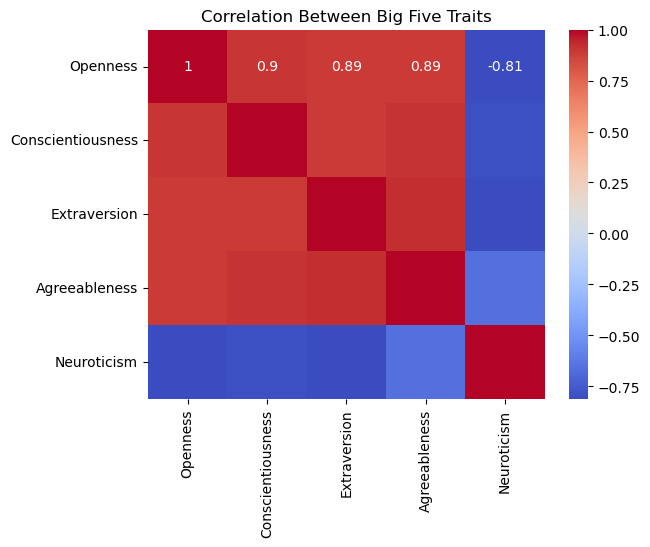

In [77]:
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Between Big Five Traits")
plt.show()

## PCA performed to notably before clustering for:
- noise reduction
- decorrelation

While the feature space is low-dimensional (5 traits), psychometric data typically exhibits high multicollinearity. I applied Principal Component Analysis (PCA) as a pre-processing step to transform raw scores into linearly uncorrelated components. By focusing on the top three components (capturing ~97% of total variance), I ensured that the clustering algorithms prioritize the primary statistical signal while filtering out residual noise from the NLP extraction process.

In [79]:
pca = PCA(n_components=3)
feats_pcs = pca.fit_transform(df4[column_names])

In [83]:
print(pca.explained_variance_ratio_)
# Total explained variance
print(pca.explained_variance_ratio_.sum())

[0.88012552 0.07145593 0.02412683]
0.975708274780565


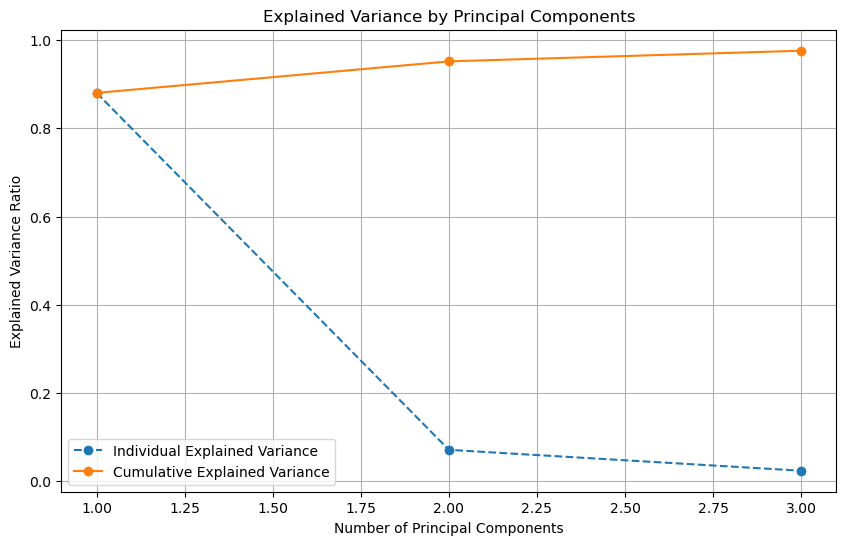

In [85]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--', label='Individual Explained Variance')
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-', label='Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.legend()
plt.show()

- 3 principal components explains ~97% of the data

In [87]:
pc1 = feats_pcs[:,0]
pc2 = feats_pcs[:,1]
pc3 = feats_pcs[:,2]

component1 = pd.Series(pc1, name='pc1')
component2 = pd.Series(pc2, name='pc2')
component3 = pd.Series(pc3, name='pc3')

In [89]:
df5 = pd.concat([df4, component1, component2, component3], axis=1)
df5.head()

Character  Openness  Conscientiousness  Extraversion  Agreeableness  \
0      Harry Potter  4.251198           3.208040      3.392720       3.534280   
1  Hermione Granger  4.266085           3.226329      3.392671       3.536308   
2       Ron Weasley  4.188146           3.142979      3.334800       3.488475   
3  Albus Dumbledore  4.360914           3.358438      3.519773       3.627857   
4     Rubeus Hagrid  4.219483           3.158740      3.354983       3.474622   

   Neuroticism  Num_Chunks_Analyzed  Openness_scaled  \
0     2.583630                   45        -0.990045   
1     2.578651                   24        -0.739720   
2     2.614824                   22        -2.050260   
3     2.459145                   21         0.854821   
4     2.584393                   12        -1.523316   

   Conscientiousness_scaled  Extraversion_scaled  Agreeableness_scaled  \
0                 -1.298634            -0.957201             -1.121734   
1                 -1.081705            -0.957929             -1.083939   
2                 -2.070358            -1.820253             -1.975633   
3                  0.485307             0.935990              0.622684   
4                 -1.883400            -1.519508             -2.233873   

   Neuroticism_scaled       pc1       pc2       pc3  
0            0.786139 -2.312980 -0.203559  0.154788  
1            0.702269 -2.048080 -0.223219 -0.055361  
2            1.311554 -4.146219 -0.411959  0.237332  
3           -1.310597  1.862426 -0.597629  0.244361  
4            0.798993 -3.585591 -0.919253  0.116513

In [91]:
loadings_df = pd.DataFrame(pca.components_,
                           columns=column_names,
                           index=[f'PC{i+1}' for i in range(pca.n_components_)]).T

print("\nComponent Loadings (Impact of Big 5 traits on Each PC):\n")
# Display the top contributing emotions for each of the first 4 PCs
for i in range(3):
    pc_name = f'PC{i+1}'
    explained_var_percent = pca.explained_variance_ratio_[i] * 100
    print(f"--- {pc_name} ({explained_var_percent:.2f}% of Variance Explained) ---")
    # Sort by absolute value to see the strongest contributors
    sorted_loadings = loadings_df[pc_name].abs().sort_values(ascending=False)

    # Get the actual loading values for interpretation (positive/negative)
    top_contributors = loadings_df[pc_name].loc[sorted_loadings.index[:5]] # Display top 5 contributors
    display(top_contributors.to_frame(name=pc_name))
    print("\n")

print("These loadings indicate the strength and direction of the relationship between each original emotion and the principal components.")


Component Loadings (Impact of Big 5 traits on Each PC):

--- PC1 (88.01% of Variance Explained) ---


PC1
Extraversion_scaled       0.459385
Conscientiousness_scaled  0.457593
Openness_scaled           0.457161
Agreeableness_scaled      0.447439
Neuroticism_scaled       -0.412765



--- PC2 (7.15% of Variance Explained) ---


PC2
Neuroticism_scaled        0.828767
Agreeableness_scaled      0.540950
Conscientiousness_scaled  0.113258
Extraversion_scaled       0.085493
Openness_scaled           0.019563



--- PC3 (2.41% of Variance Explained) ---


PC3
Extraversion_scaled       0.716077
Openness_scaled          -0.497856
Conscientiousness_scaled -0.455558
Agreeableness_scaled      0.149490
Neuroticism_scaled       -0.097435



These loadings indicate the strength and direction of the relationship between each original emotion and the principal components.


In [95]:
data = df5[["pc1", "pc2", "pc3"]].to_numpy() 
print(data.shape) 

(32, 3)


In [101]:
metrics = ["euclidean", "l1", "l2", "manhattan", "cosine"]
links = ['ward', 'complete', 'average', 'single']

## compute metrics for hirarchical clustering to compare with kmeans for best solution to cluster

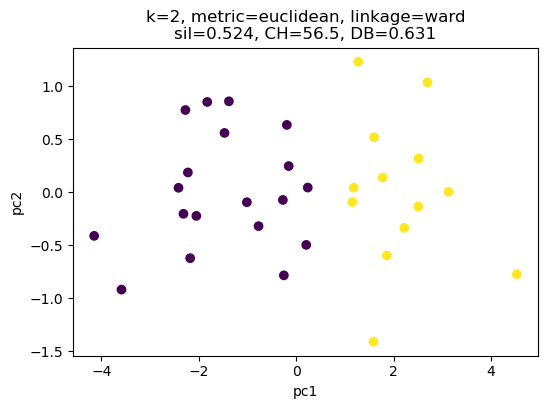

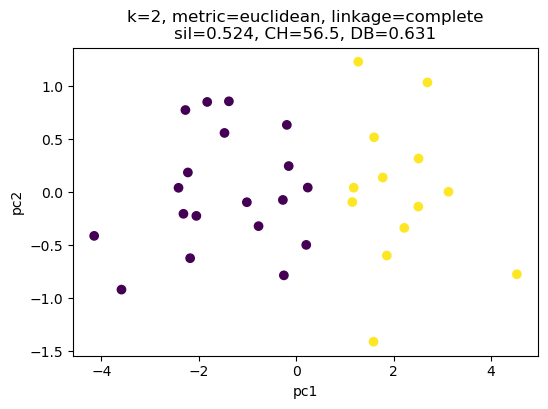

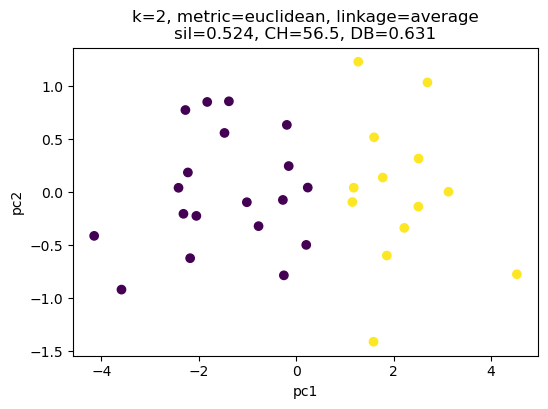

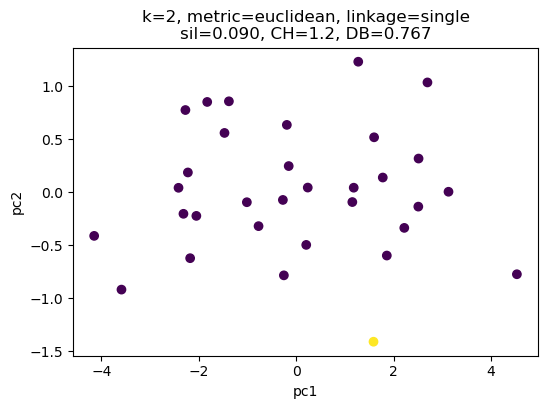

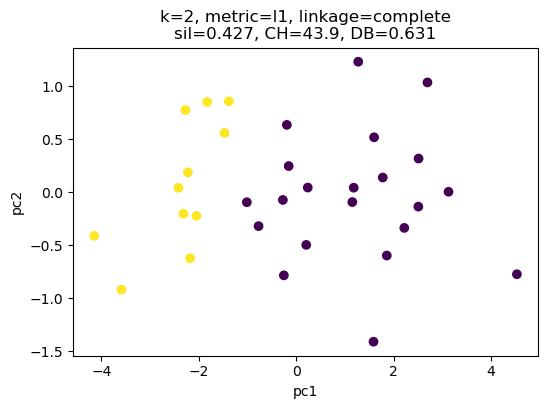

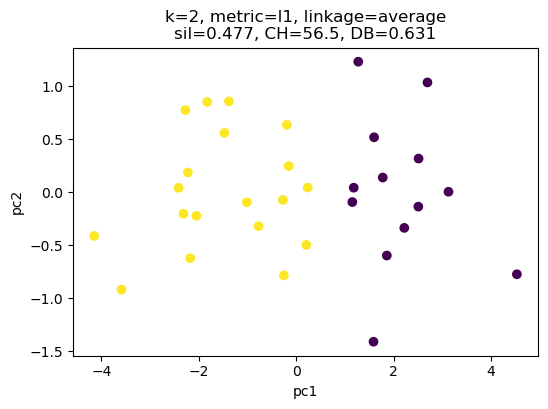

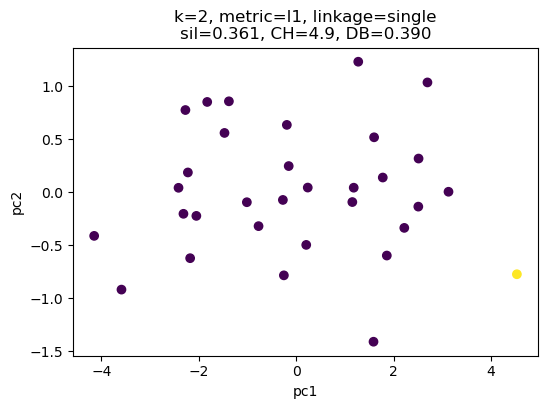

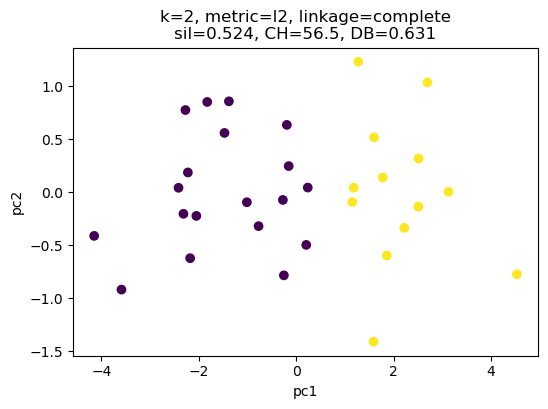

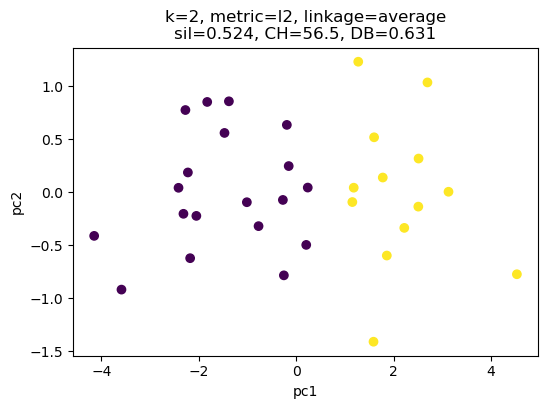

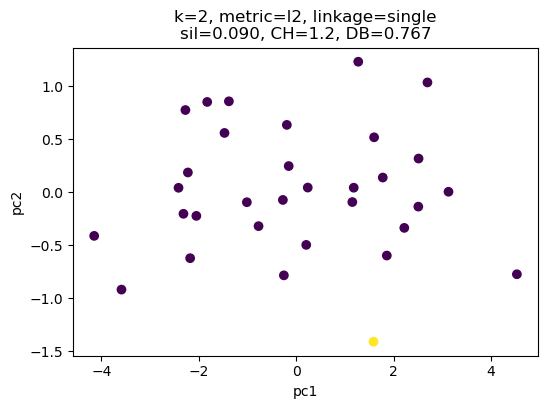

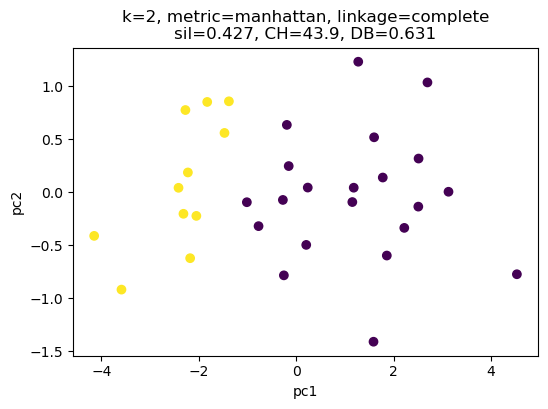

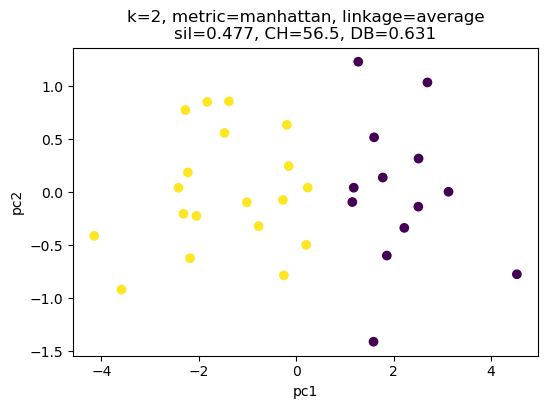

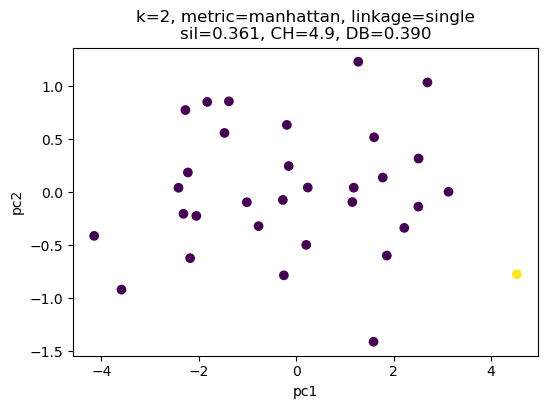

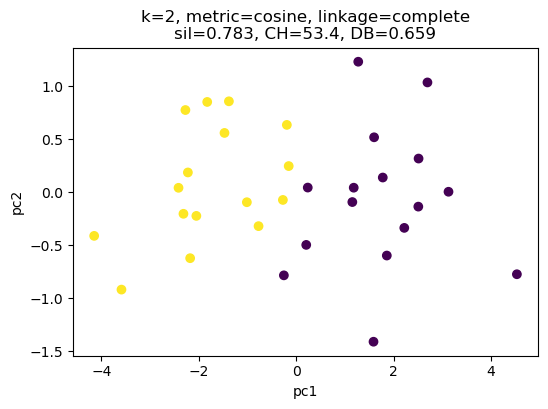

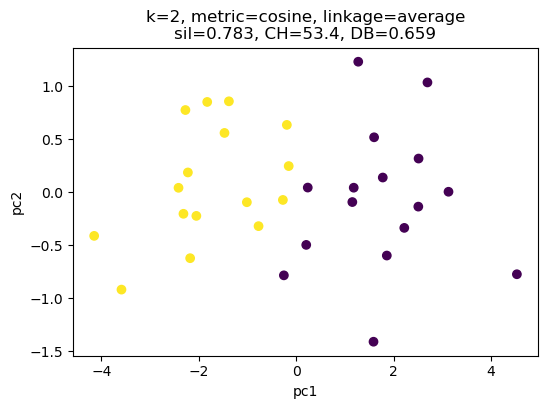

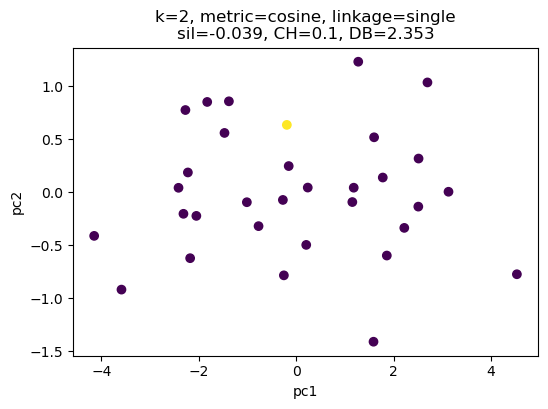

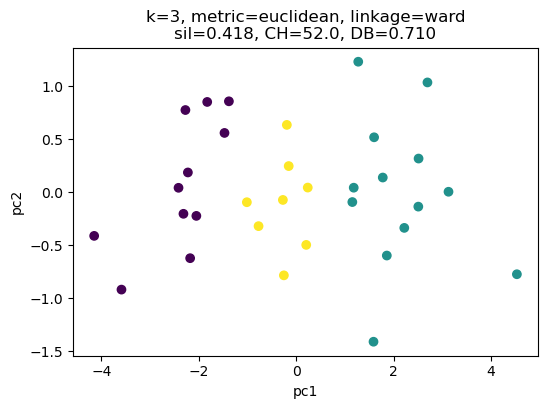

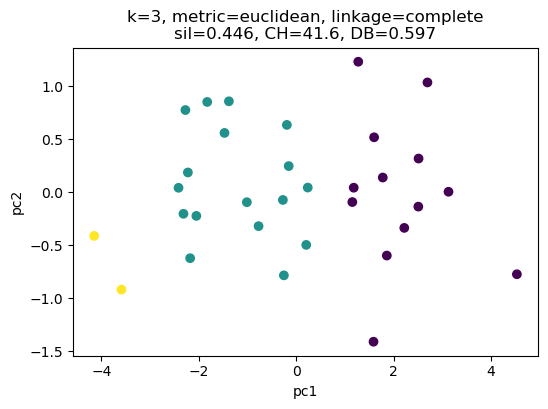

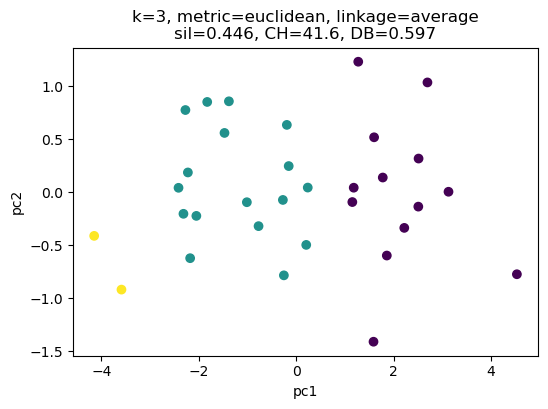

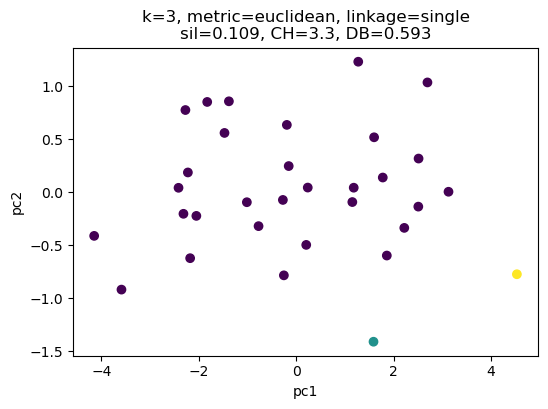

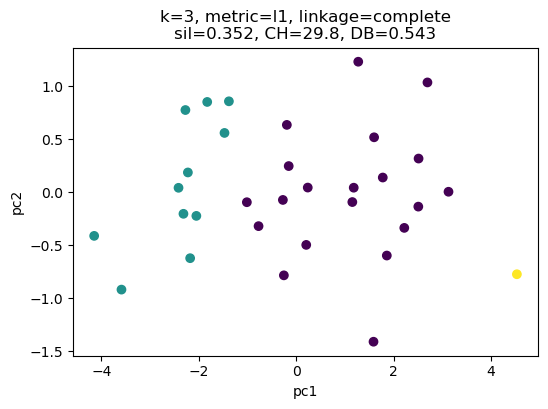

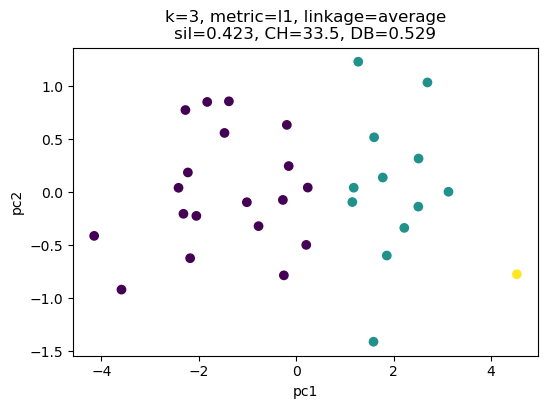

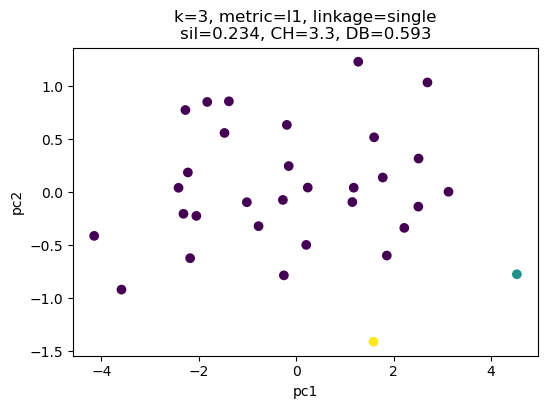

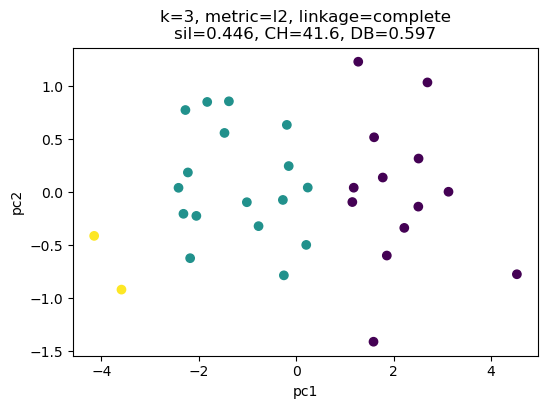

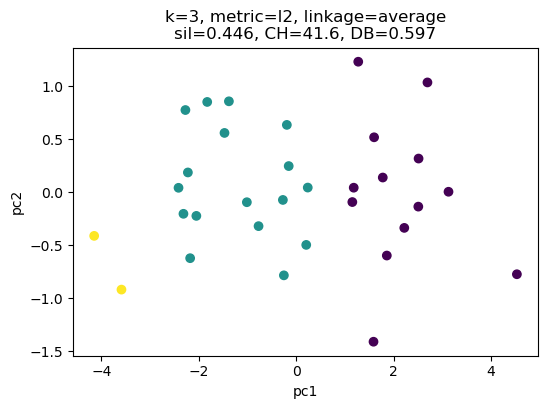

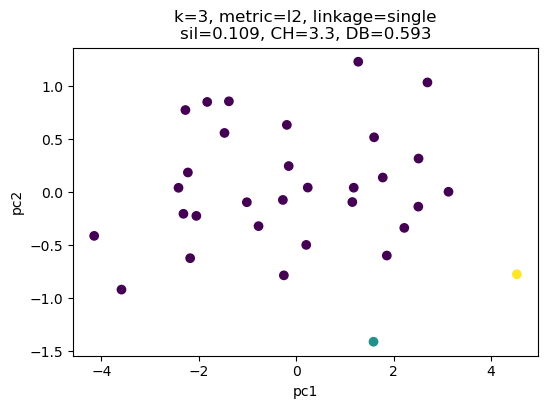

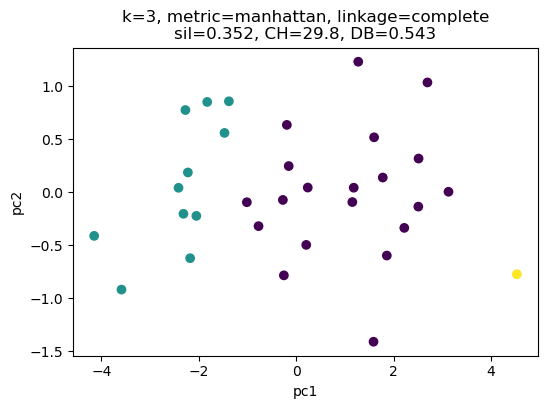

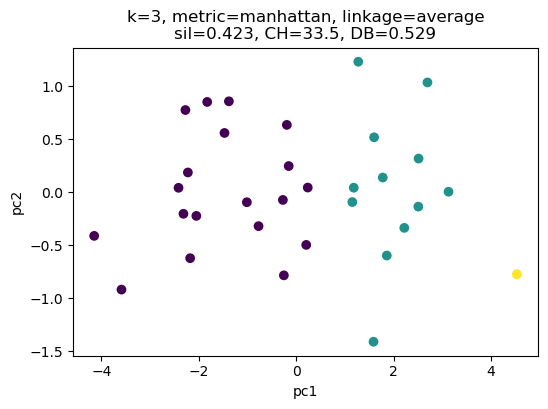

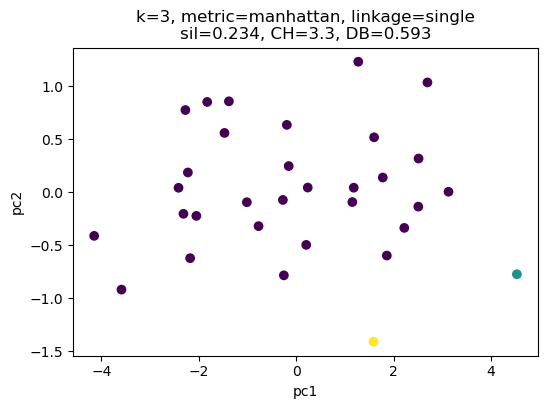

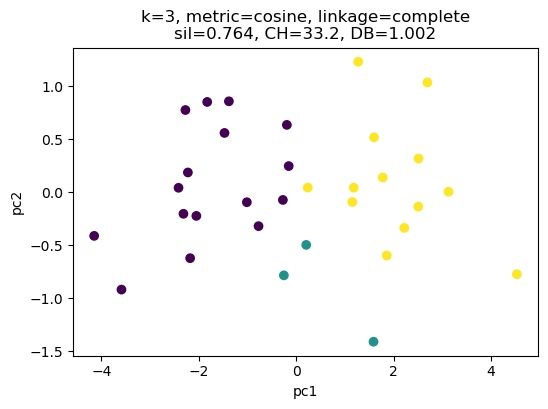

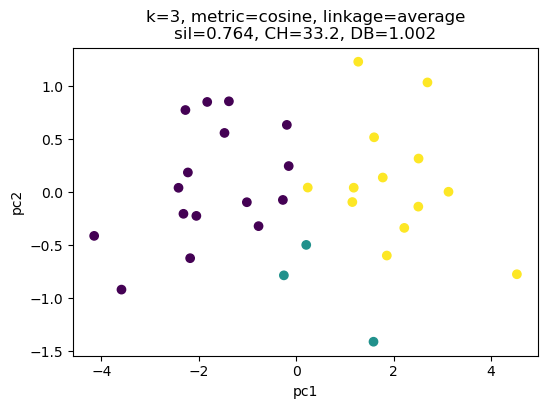

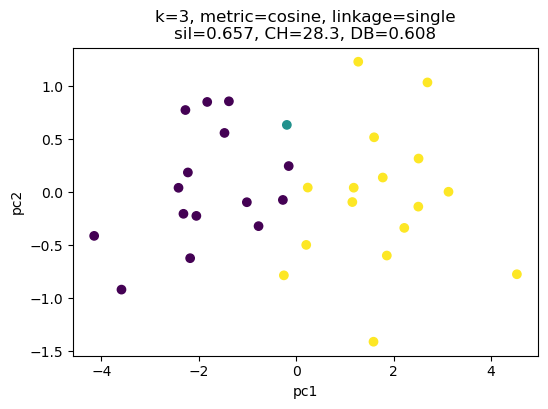

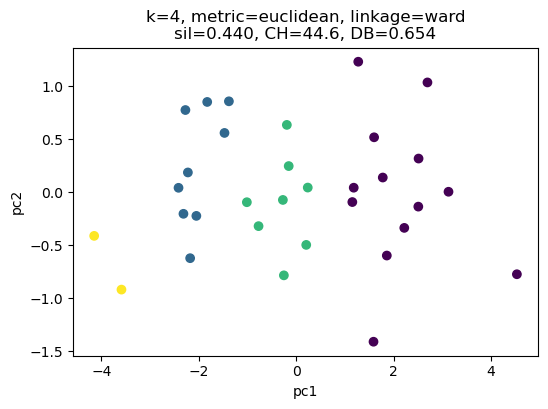

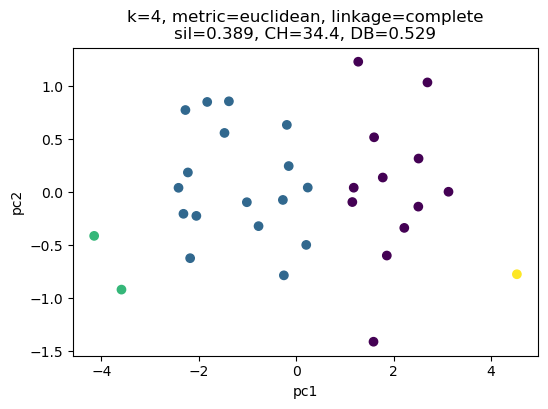

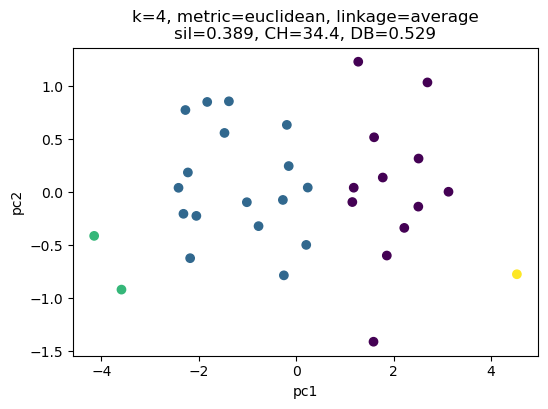

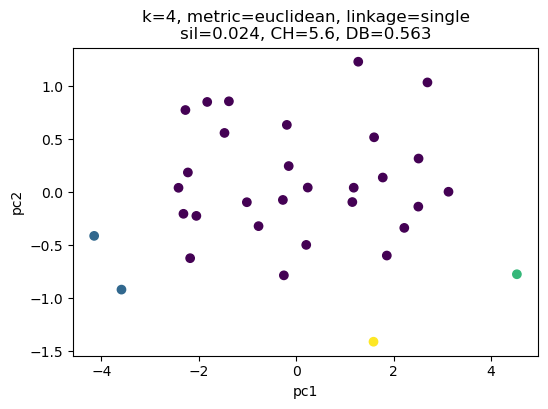

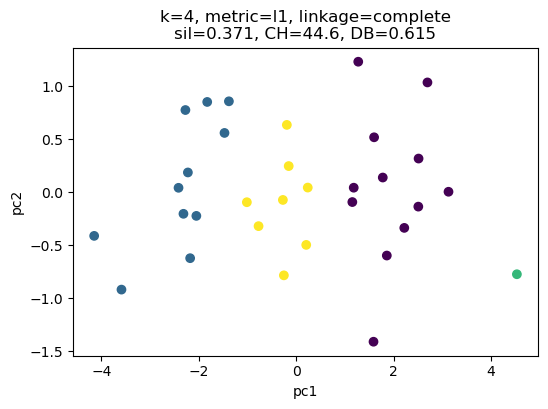

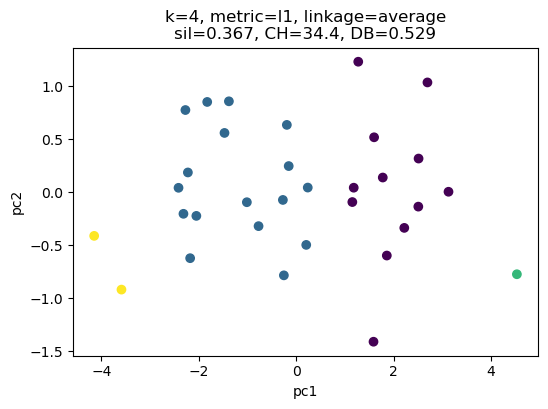

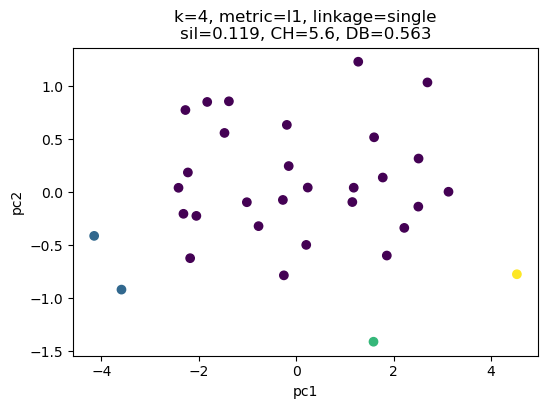

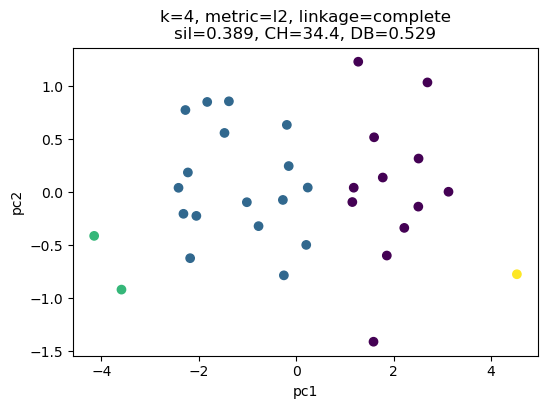

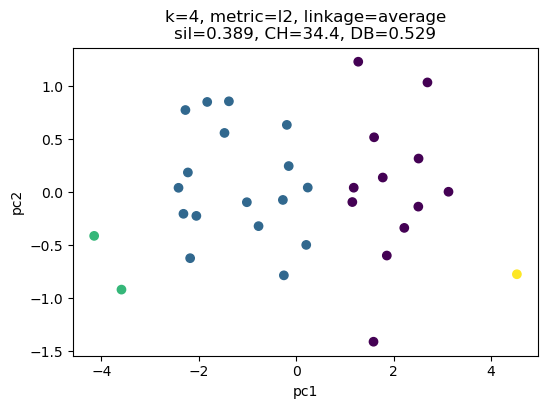

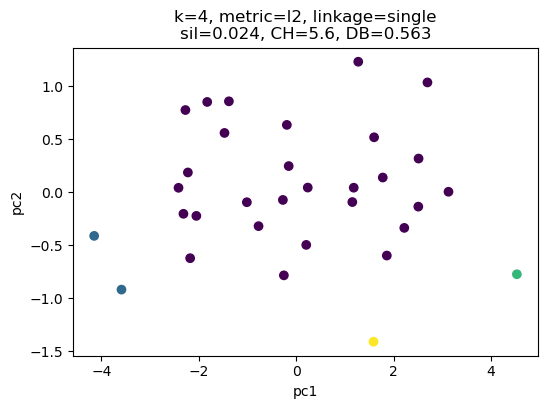

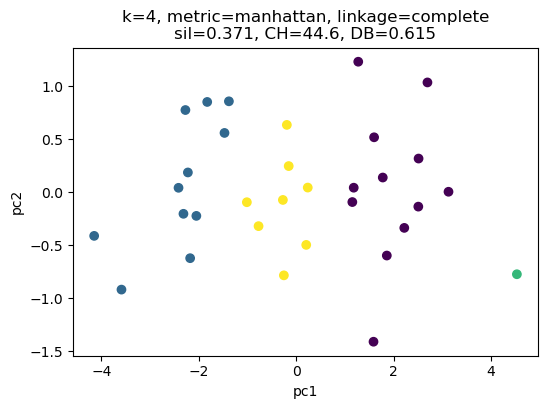

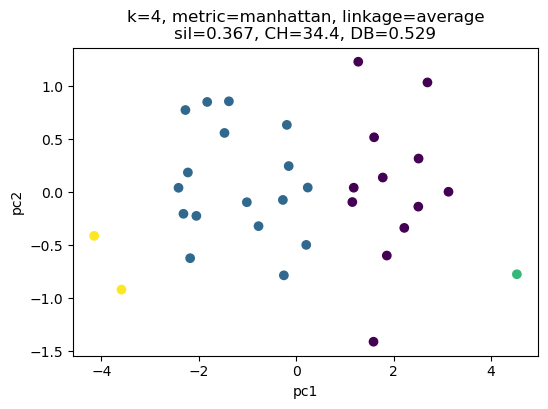

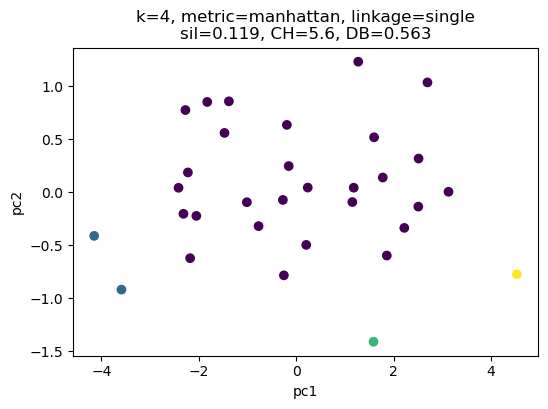

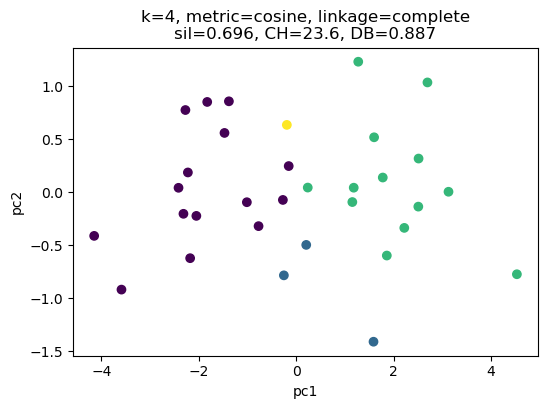

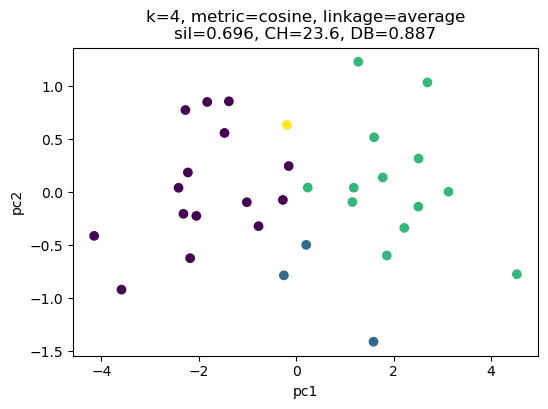

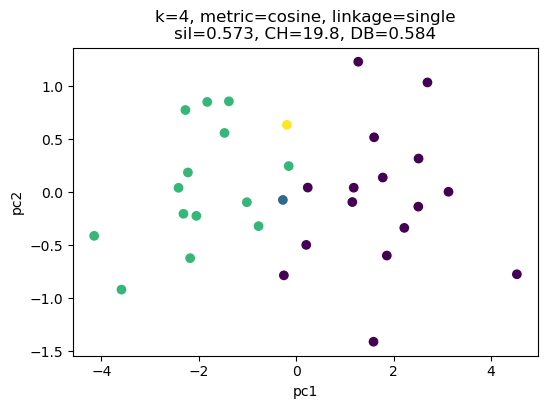

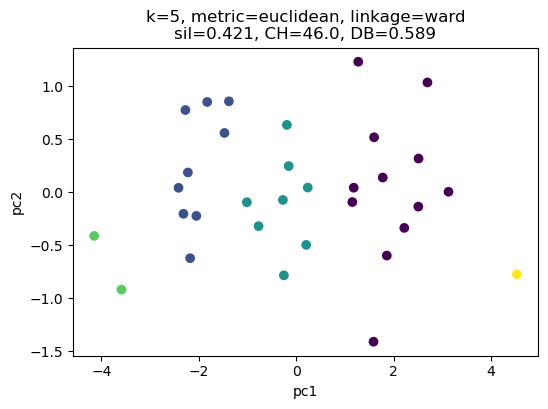

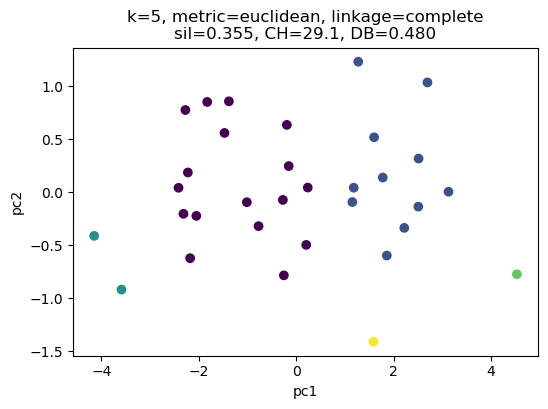

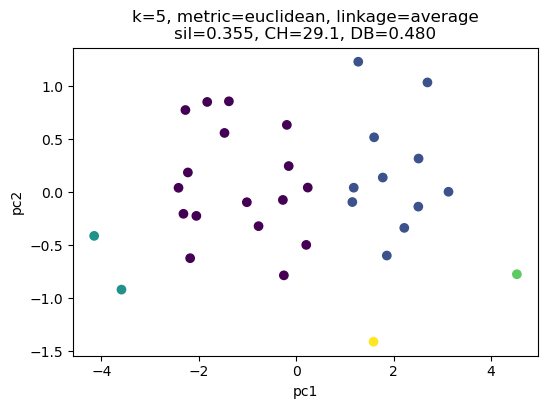

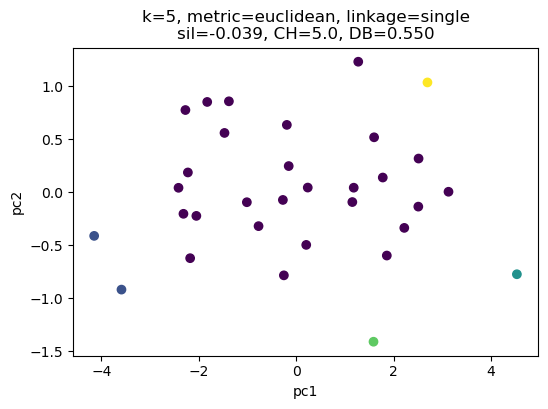

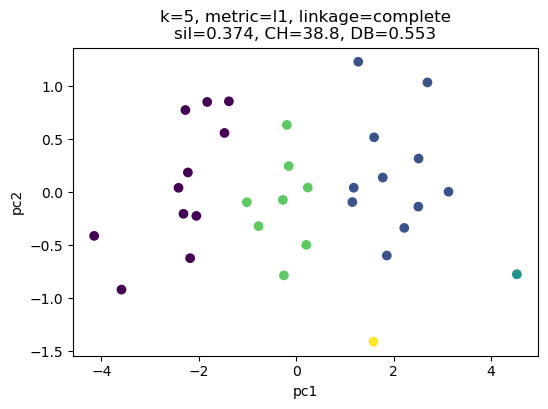

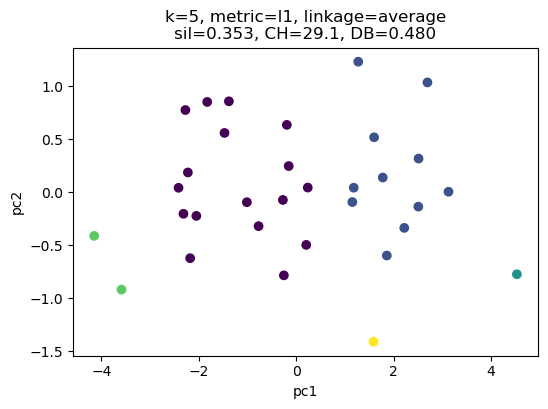

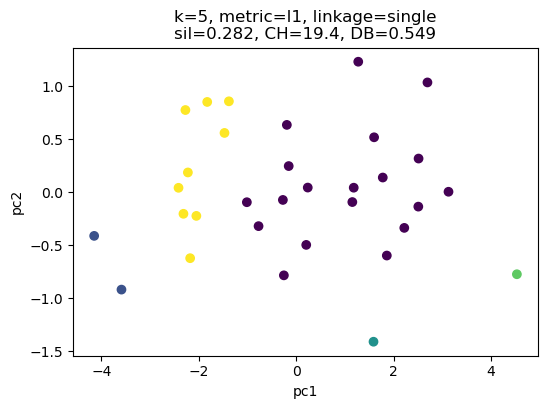

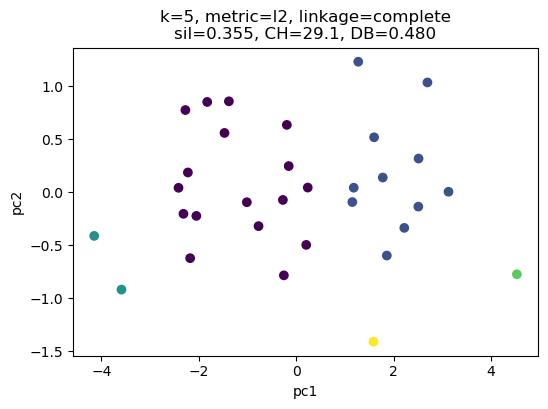

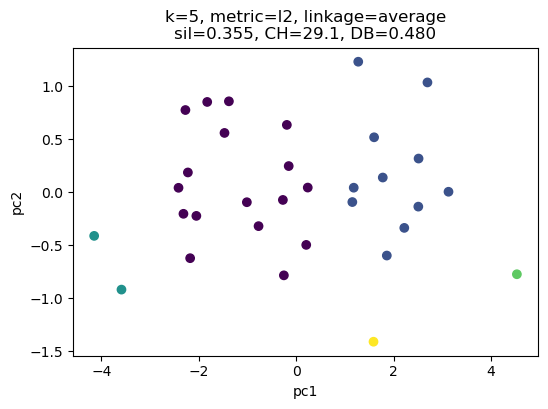

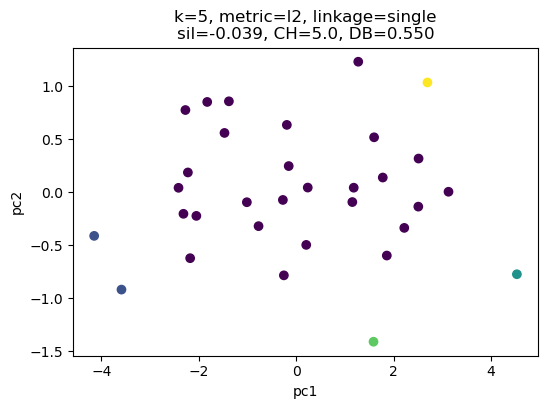

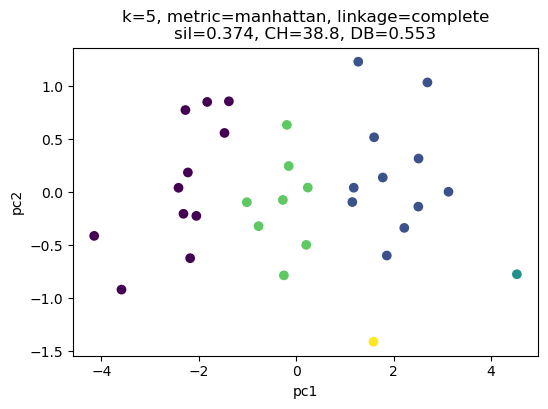

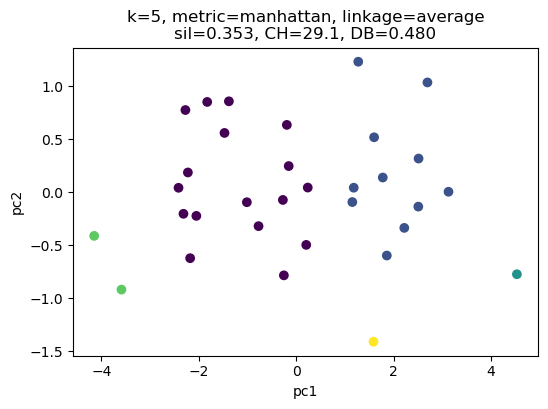

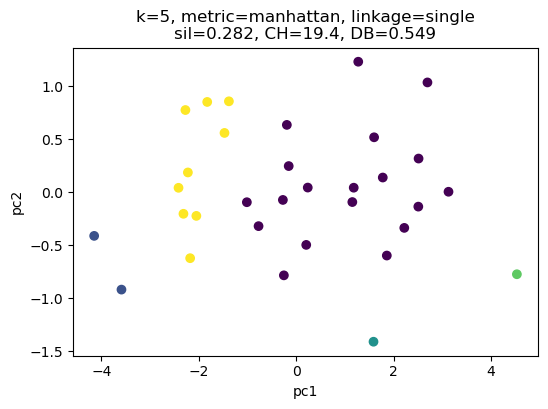

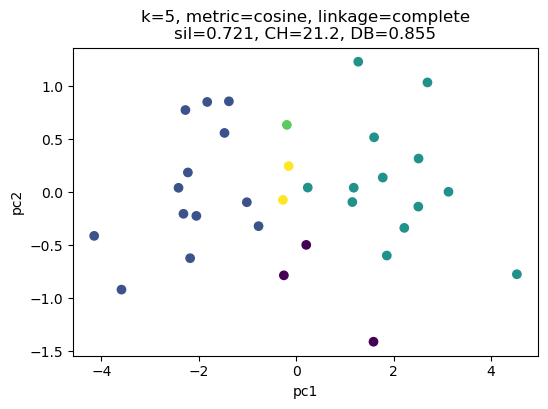

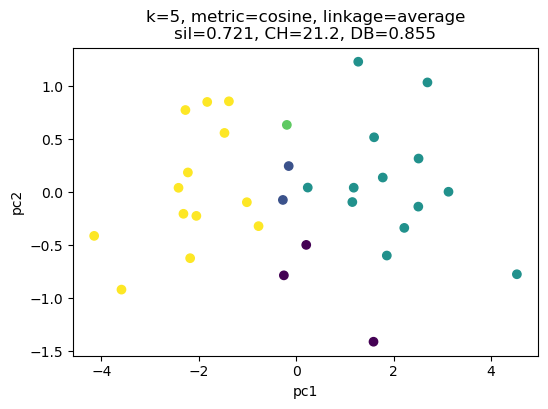

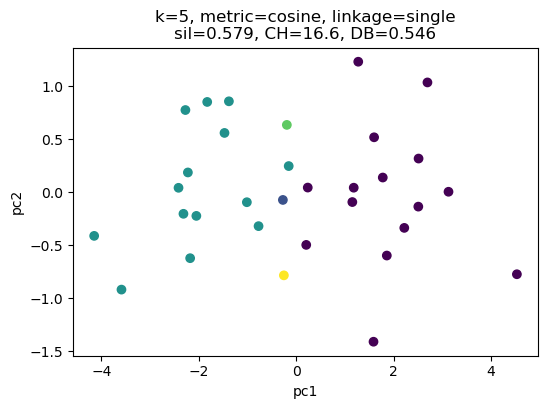

k     metric   linkage  silhouette  calinski_harabasz  davies_bouldin  \
13  2     cosine  complete    0.782963          53.387525        0.658819   
14  2     cosine   average    0.782963          53.387525        0.658819   
29  3     cosine  complete    0.764019          33.152239        1.001574   
30  3     cosine   average    0.764019          33.152239        1.001574   
61  5     cosine  complete    0.721262          21.210002        0.854568   
.. ..        ...       ...         ...                ...             ...   
35  4  euclidean    single    0.024028           5.624244        0.563179   
41  4         l2    single    0.024028           5.624244        0.563179   
51  5  euclidean    single   -0.038502           5.047516        0.549721   
57  5         l2    single   -0.038502           5.047516        0.549721   
15  2     cosine    single   -0.038792           0.133112        2.353135   

    n_clusters_found  
13                 2  
14                 2  
29                 3  
30                 3  
61                 5  
..               ...  
35                 4  
41                 4  
51                 5  
57                 5  
15                 2  

[64 rows x 7 columns]

In [103]:
results = []

for k in range(2, 6):
    for metric_name in metrics:
        for linkage_name in links:
            # ward requires euclidean distance
            if linkage_name == "ward" and metric_name != "euclidean":
                continue

            # Fit hierarchical clustering
            model = AgglomerativeClustering(
                n_clusters=k,
                metric=metric_name,     # if sklearn errors, change to affinity=metric_name
                linkage=linkage_name
            )
            labels = model.fit_predict(data)

            # Some metrics require >1 cluster and <n_samples clusters
            n_unique = len(np.unique(labels))
            if n_unique < 2 or n_unique >= len(data):
                continue

            # ---- Compute evaluation metrics ----
            # Silhouette:
            # - if metric is not euclidean, safest is to compute on a precomputed distance matrix
            try:
                if metric_name == "euclidean":
                    sil = silhouette_score(data, labels, metric="euclidean")
                else:
                    D = pairwise_distances(data, metric=metric_name)
                    sil = silhouette_score(D, labels, metric="precomputed")
            except Exception:
                sil = np.nan

            # CH and DB are defined on feature space (they assume euclidean geometry).
            # They're still often used on PCA/standardized numeric data. If using
            # non-euclidean distances, interpret cautiously.
            try:
                ch = calinski_harabasz_score(data, labels)
            except Exception:
                ch = np.nan

            try:
                db = davies_bouldin_score(data, labels)
            except Exception:
                db = np.nan

            results.append({
                "k": k,
                "metric": metric_name,
                "linkage": linkage_name,
                "silhouette": sil,
                "calinski_harabasz": ch,
                "davies_bouldin": db,
                "n_clusters_found": n_unique
            })

            
            plt.figure(figsize=(6, 4))
            plt.scatter(df5["pc1"], df5["pc2"], c=labels)
            plt.title(f"k={k}, metric={metric_name}, linkage={linkage_name}\n"
                      f"sil={sil:.3f}, CH={ch:.1f}, DB={db:.3f}")
            plt.xlabel("pc1")
            plt.ylabel("pc2")
            plt.show()

# Put results DataFrame for easy sorting/filtering
results_df1 = pd.DataFrame(results)

# sort by best silhouette (descending) and best DB (ascending)
display(results_df1.sort_values(["silhouette", "davies_bouldin"], ascending=[False, True]))


In [105]:
results_df1.sort_values(["silhouette", "davies_bouldin"], ascending=[False, True]).head(10)
# show the top 10 scores (silhouette) from k=2-5

k  metric   linkage  silhouette  calinski_harabasz  davies_bouldin  \
13  2  cosine  complete    0.782963          53.387525        0.658819   
14  2  cosine   average    0.782963          53.387525        0.658819   
29  3  cosine  complete    0.764019          33.152239        1.001574   
30  3  cosine   average    0.764019          33.152239        1.001574   
61  5  cosine  complete    0.721262          21.210002        0.854568   
62  5  cosine   average    0.721262          21.210002        0.854568   
45  4  cosine  complete    0.695846          23.574601        0.886713   
46  4  cosine   average    0.695846          23.574601        0.886713   
31  3  cosine    single    0.657131          28.260540        0.608453   
63  5  cosine    single    0.579071          16.612958        0.546438   

    n_clusters_found  
13                 2  
14                 2  
29                 3  
30                 3  
61                 5  
62                 5  
45                 4  
46                 4  
31                 3  
63                 5

- check metrics for k=6-10

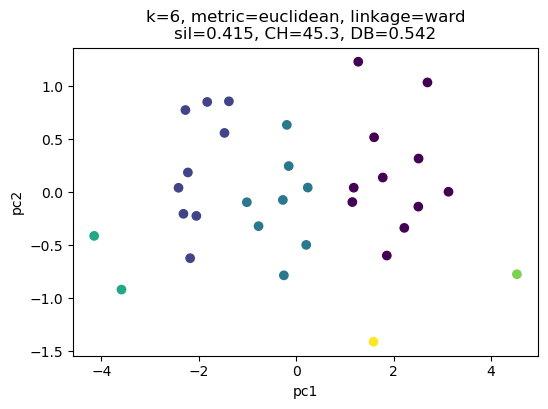

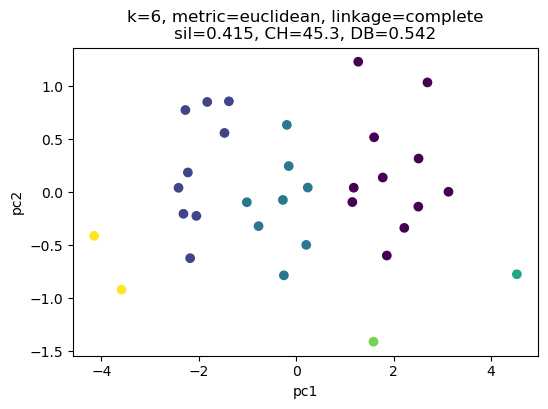

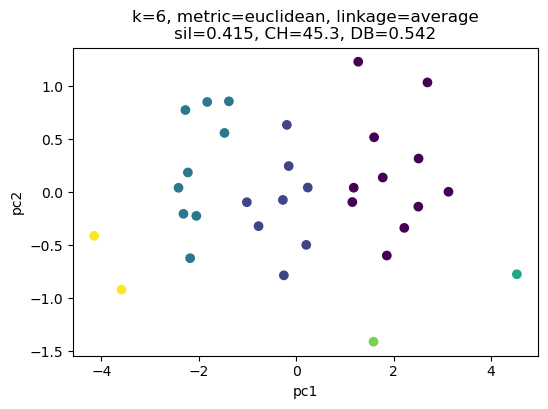

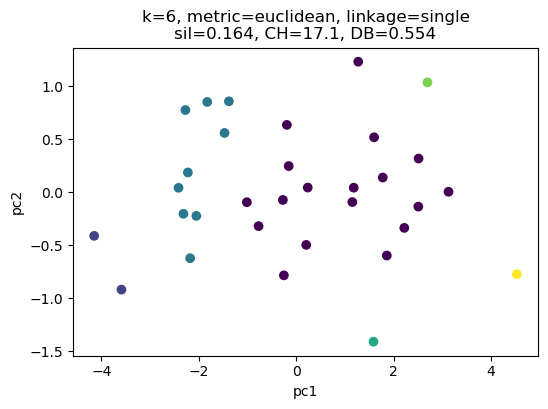

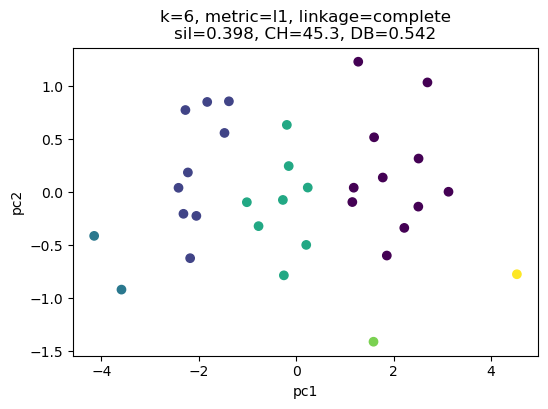

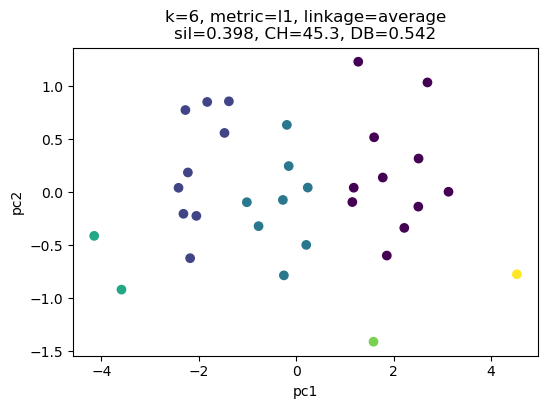

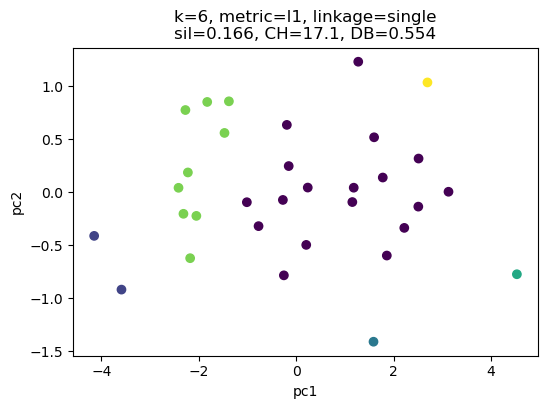

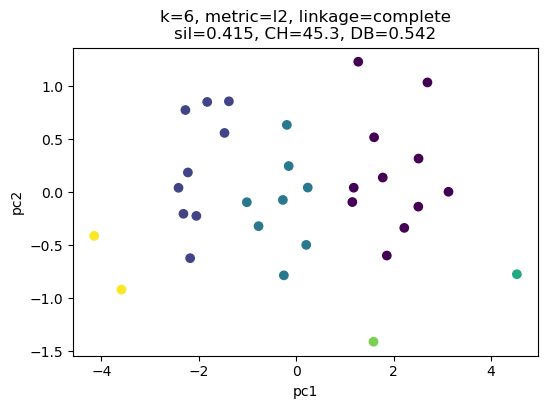

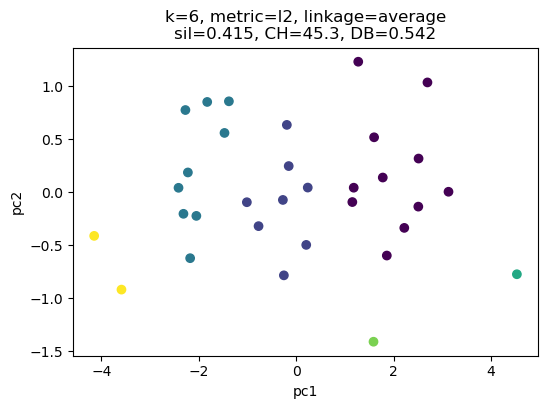

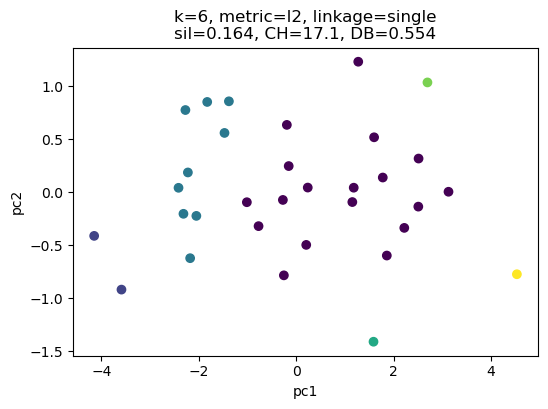

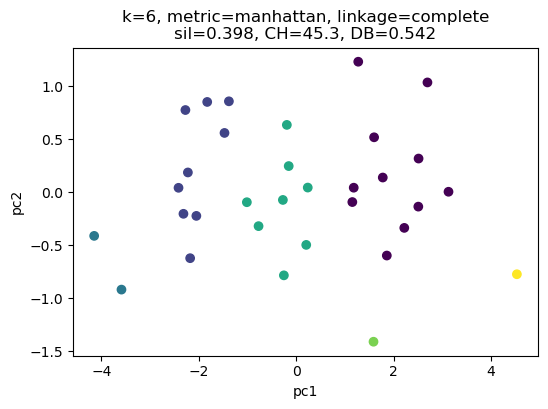

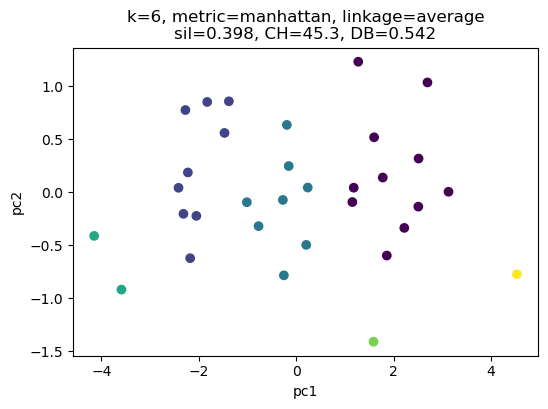

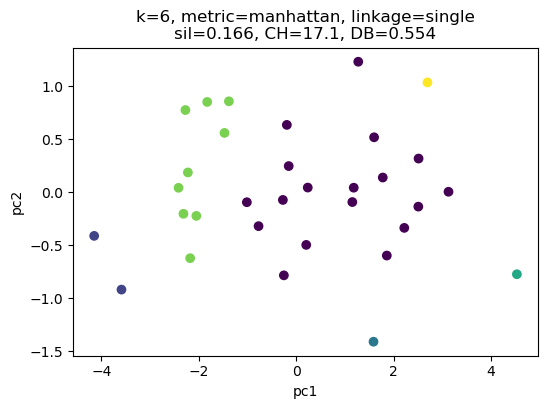

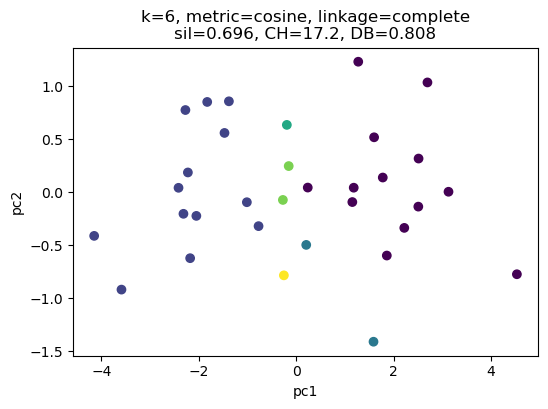

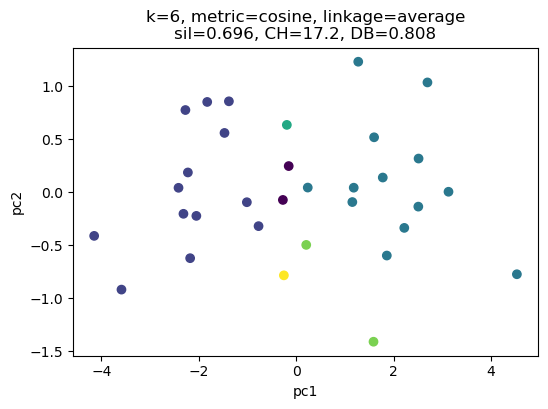

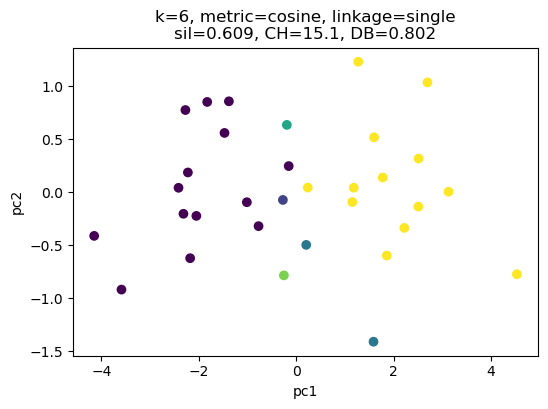

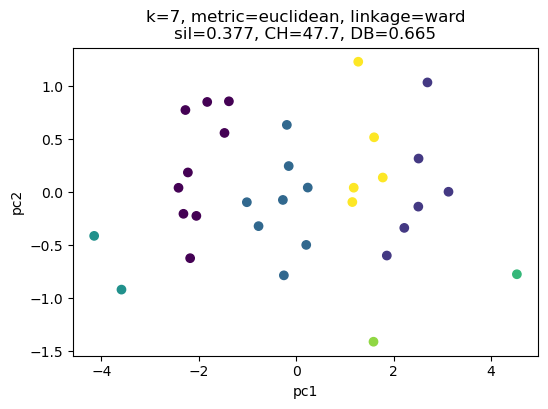

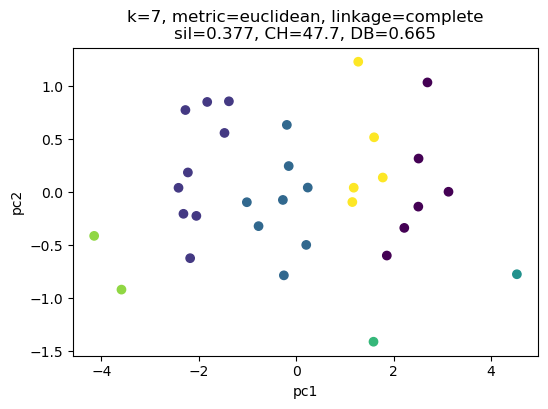

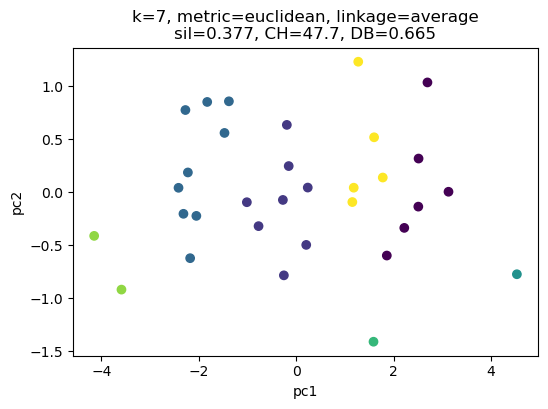

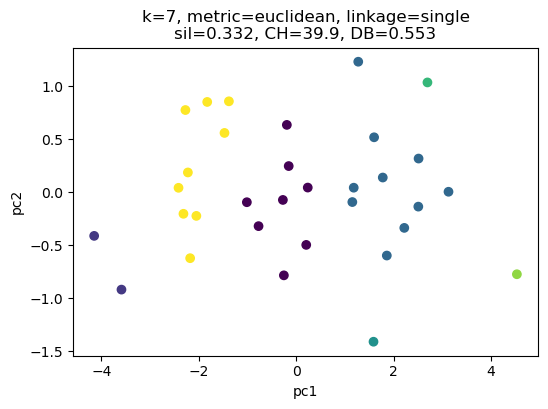

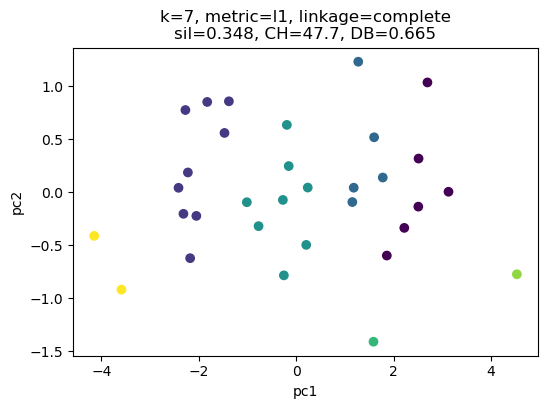

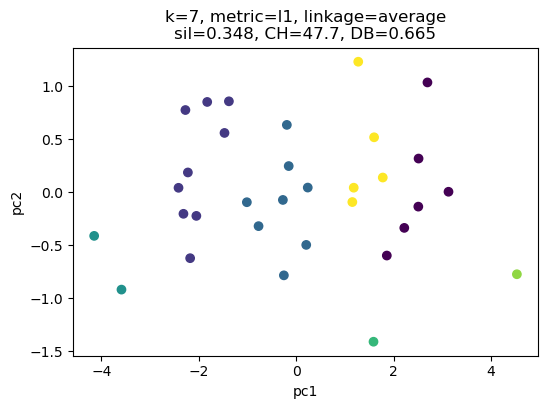

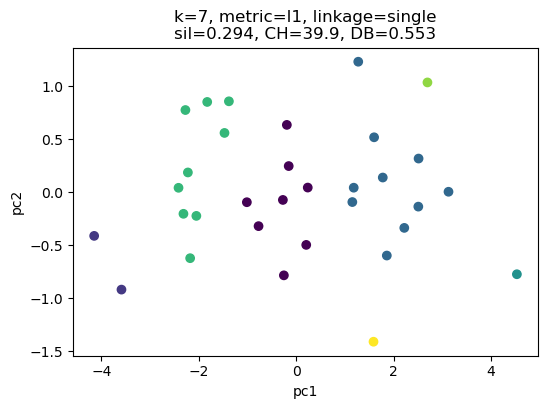

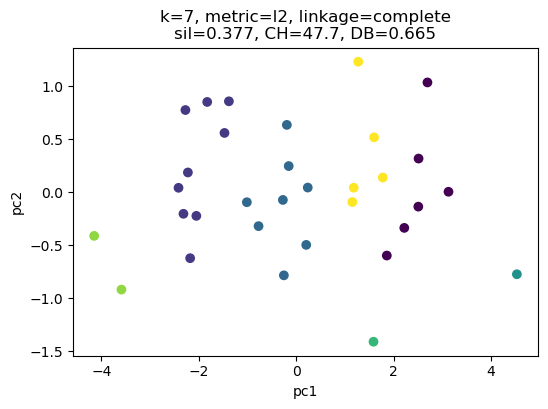

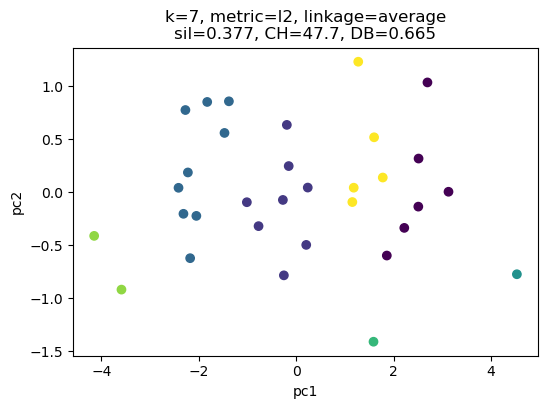

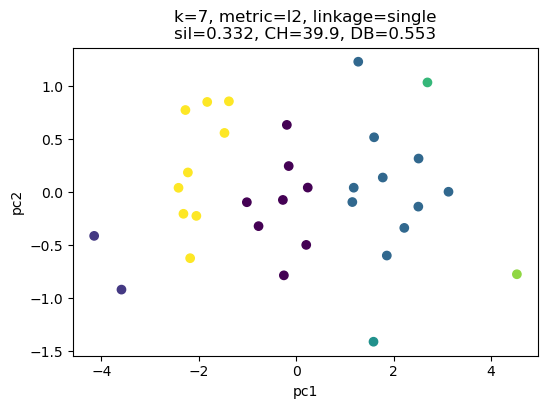

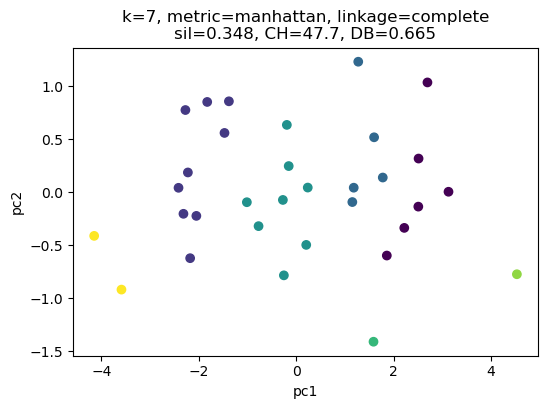

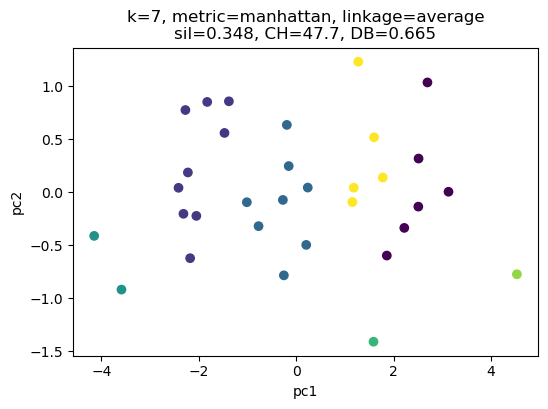

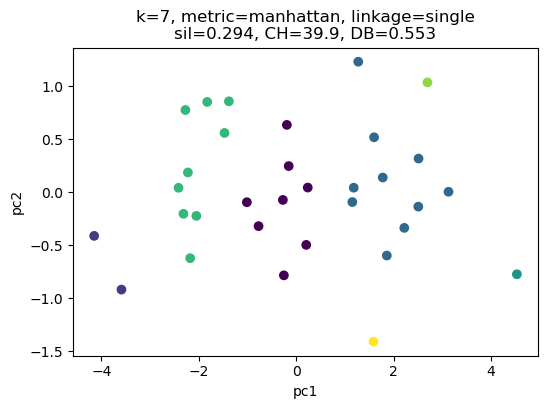

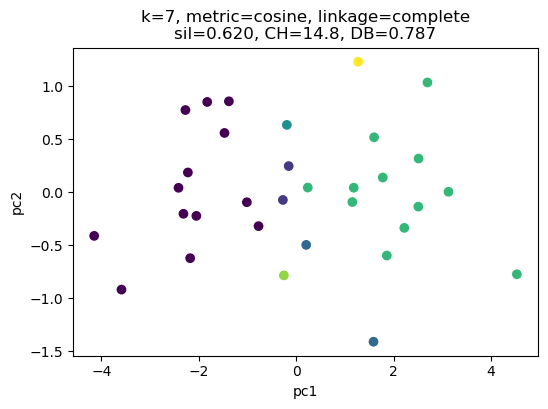

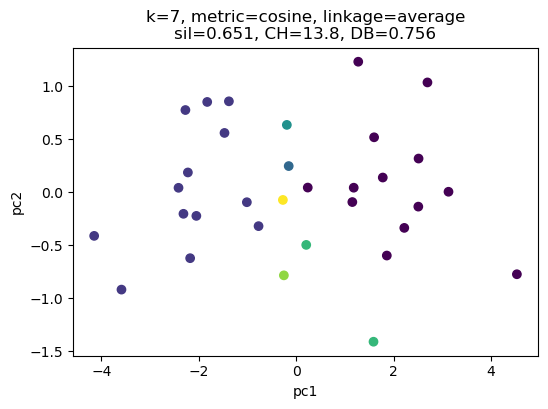

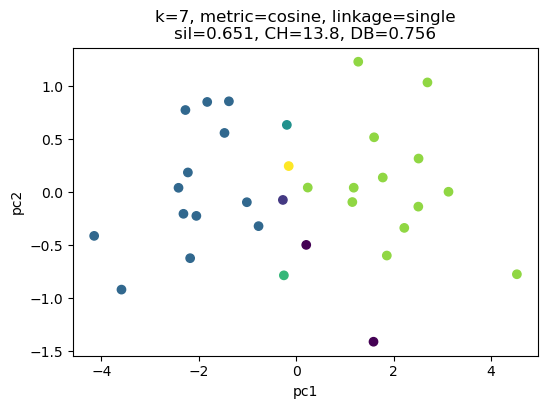

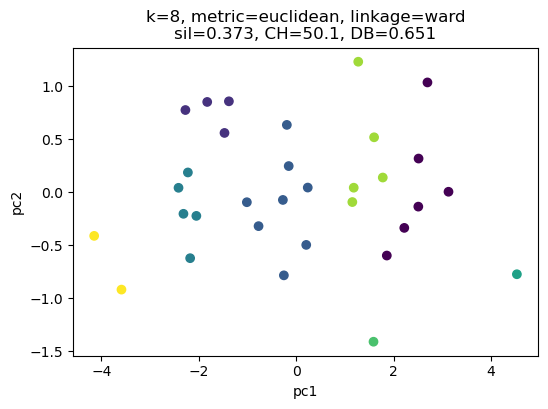

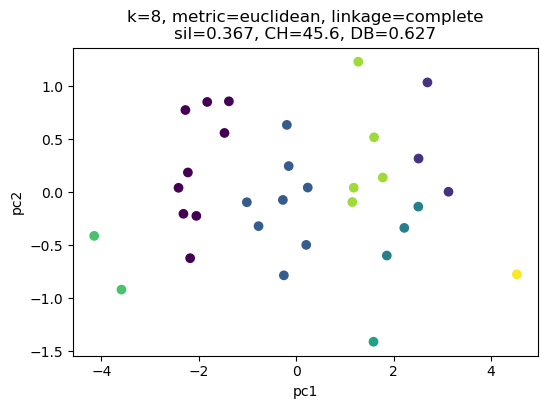

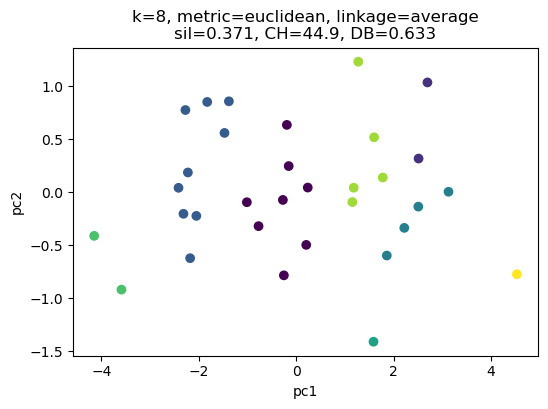

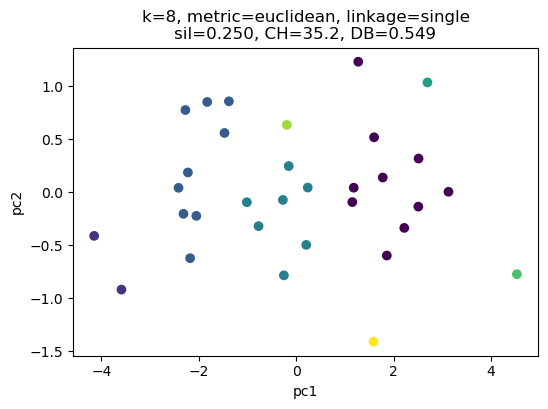

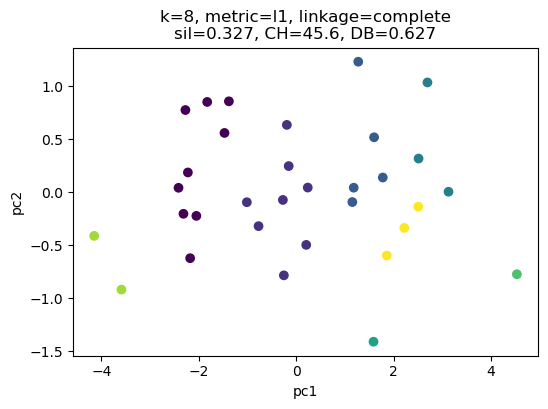

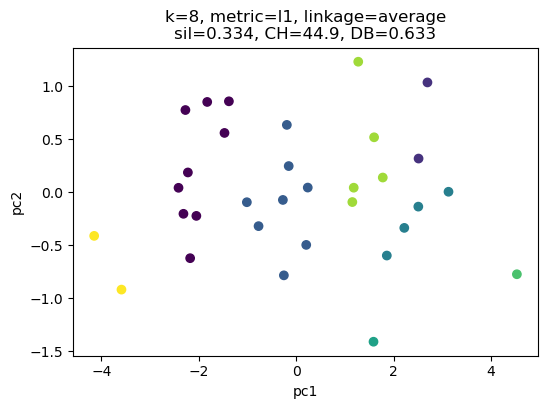

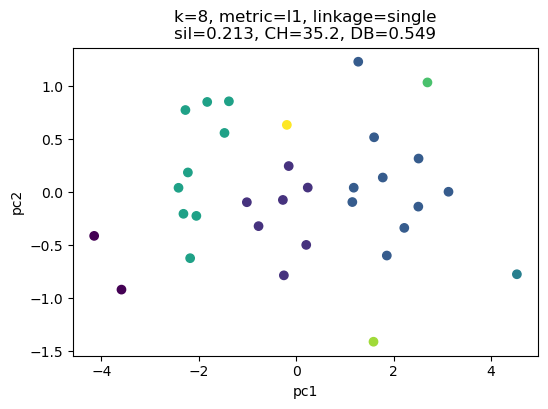

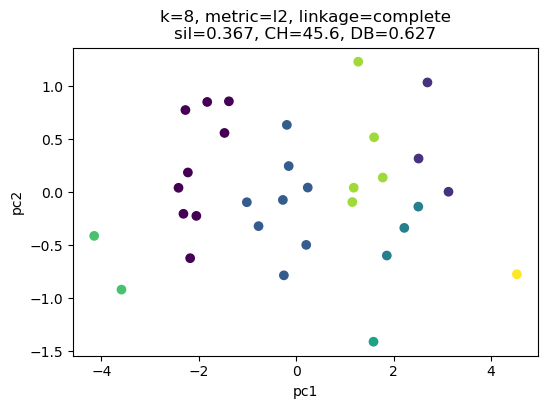

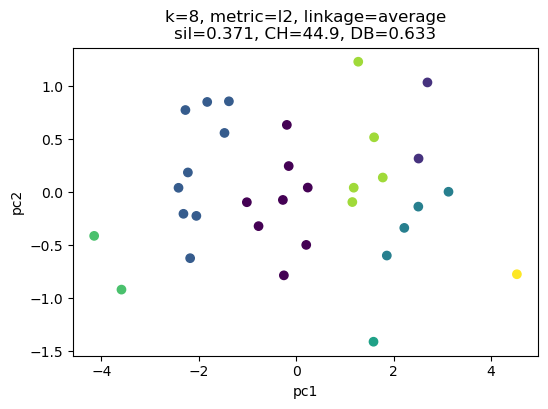

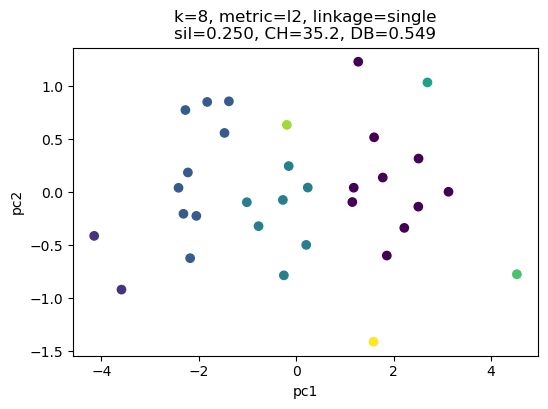

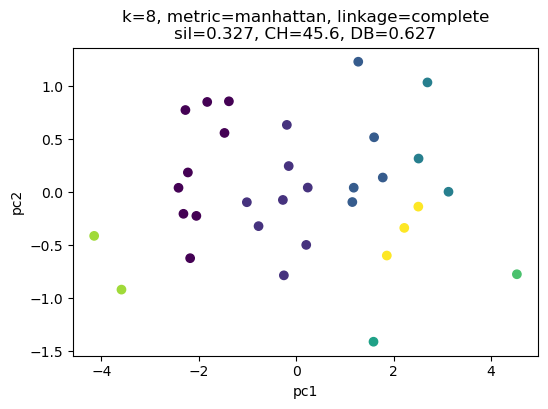

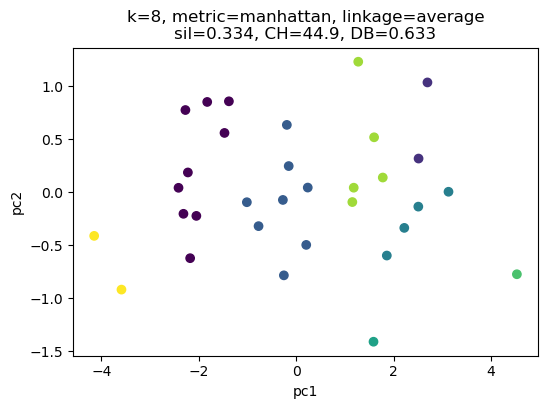

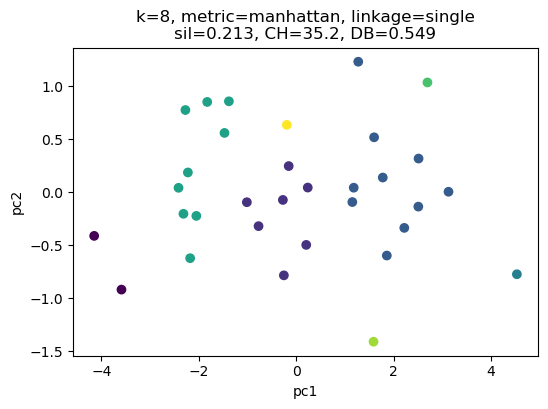

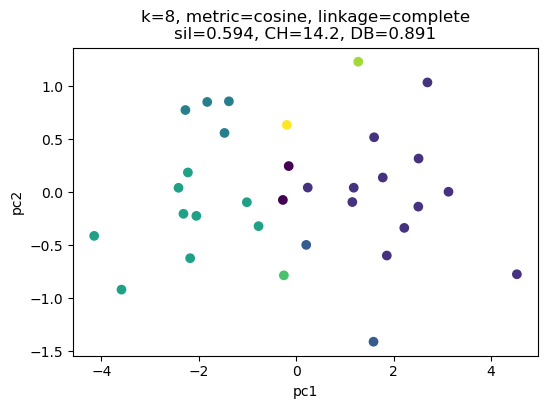

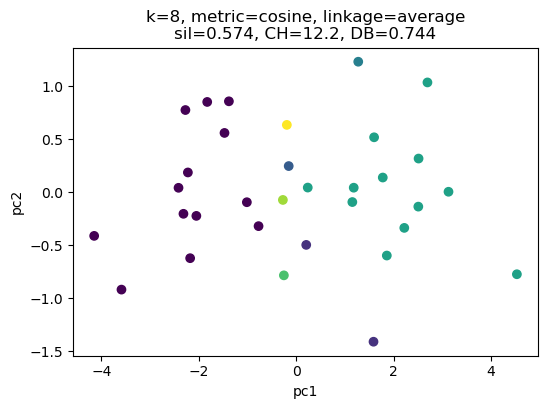

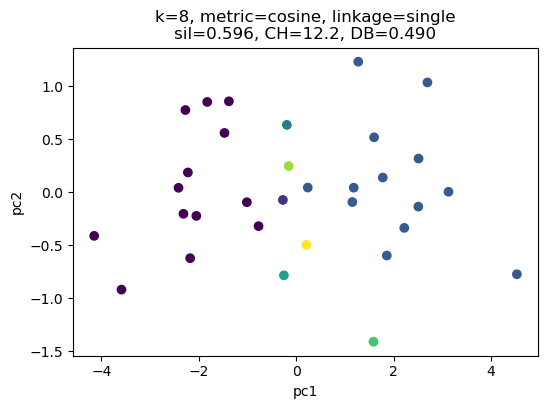

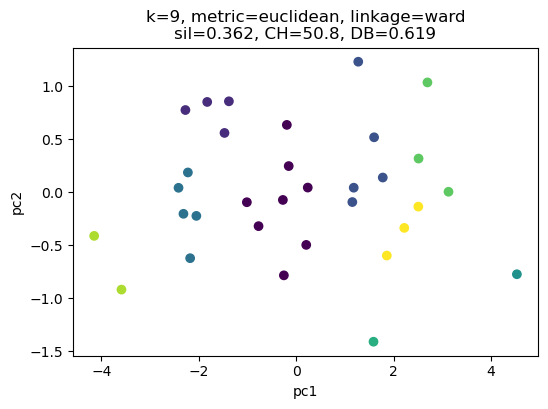

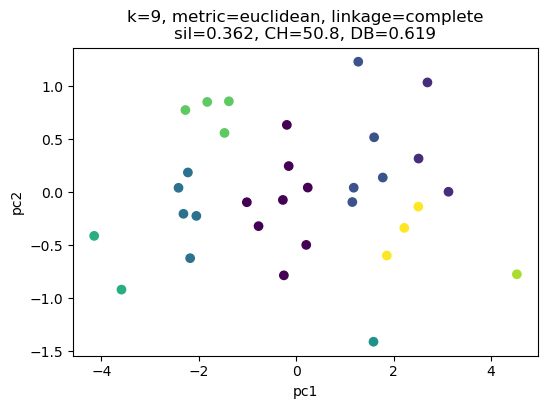

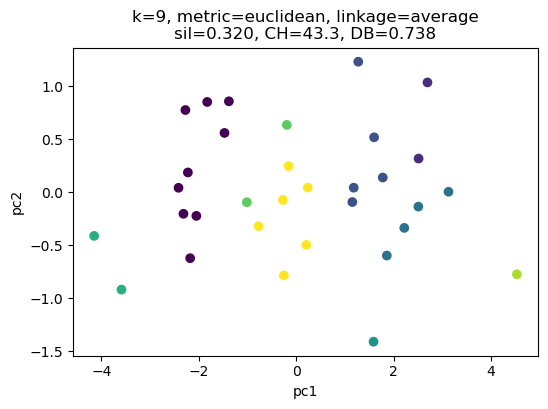

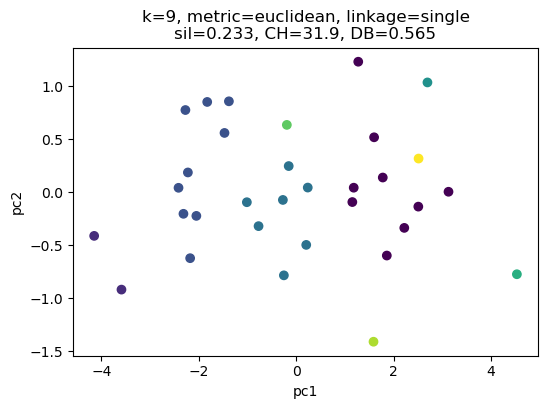

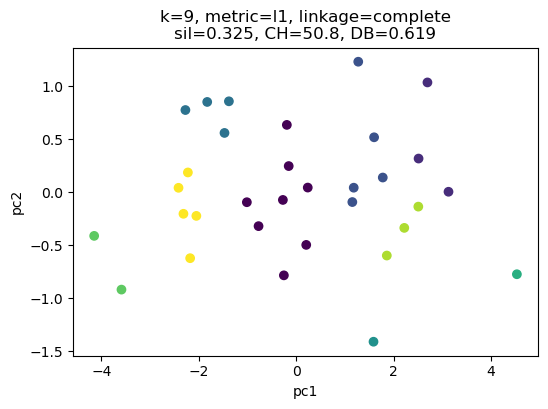

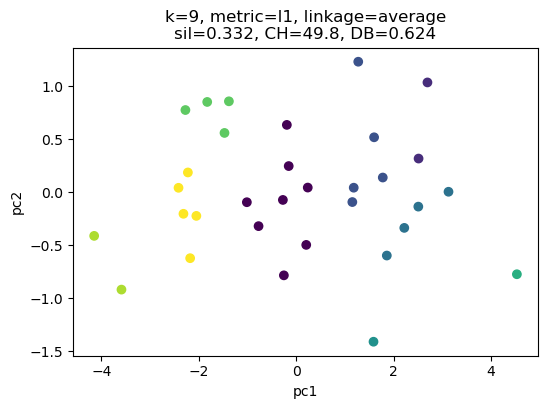

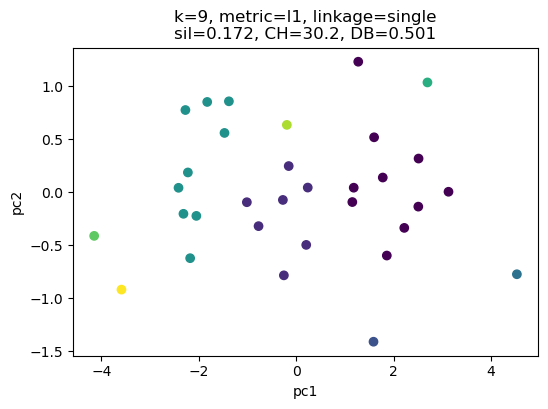

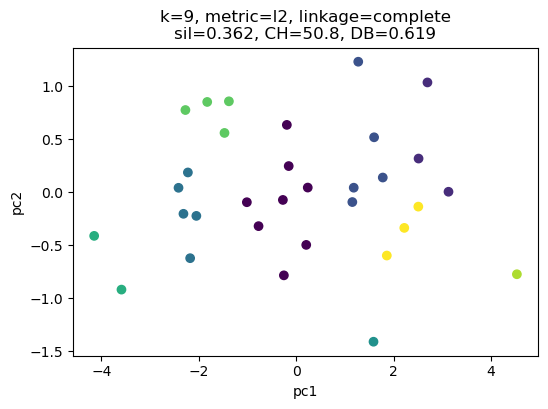

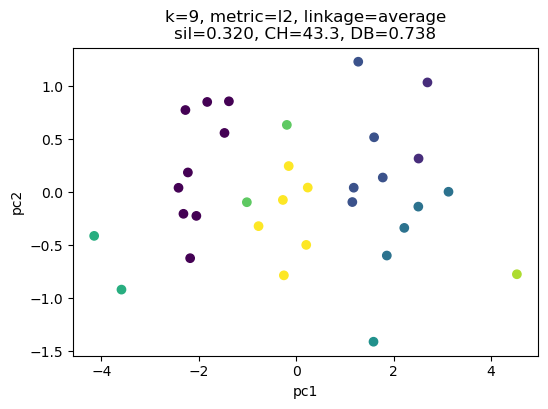

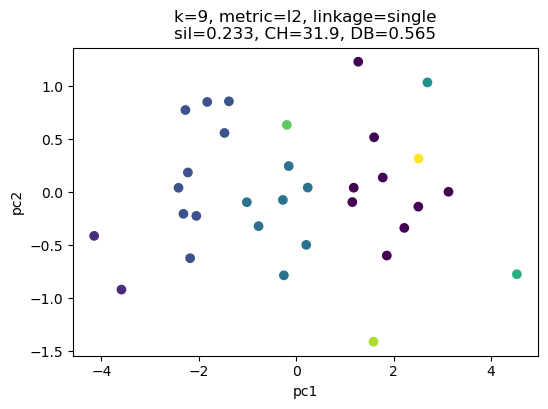

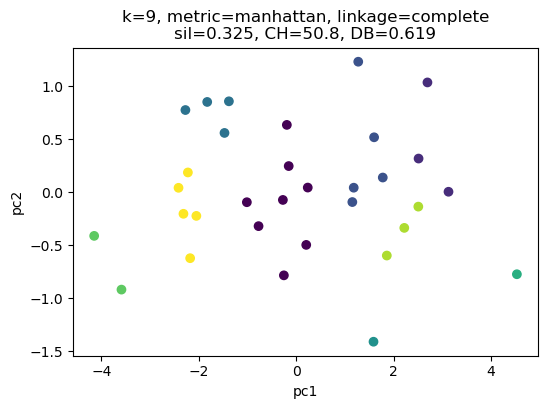

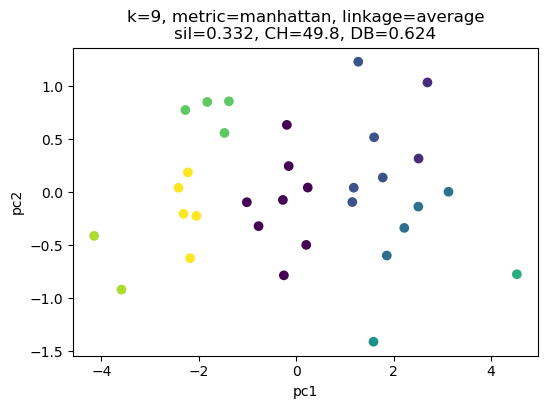

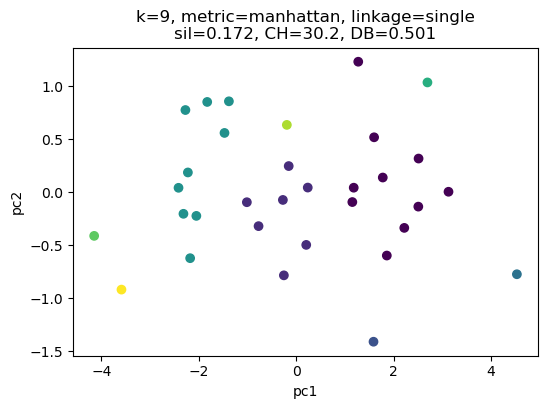

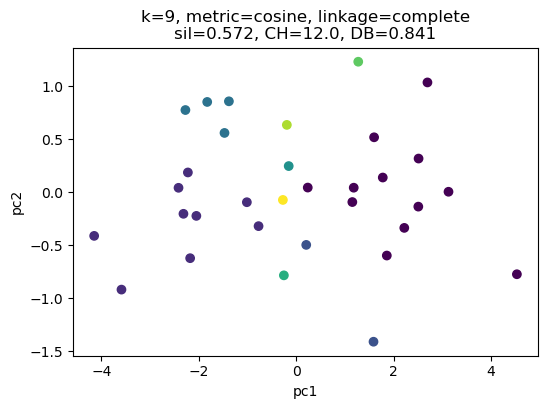

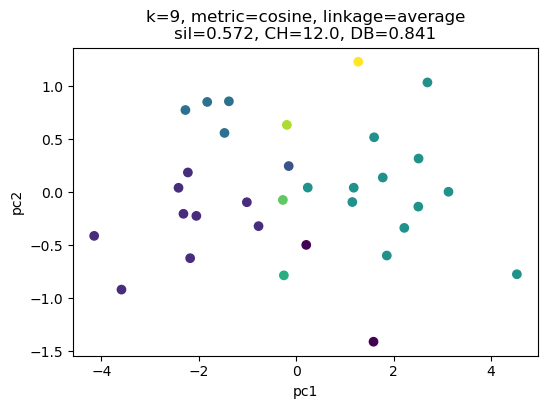

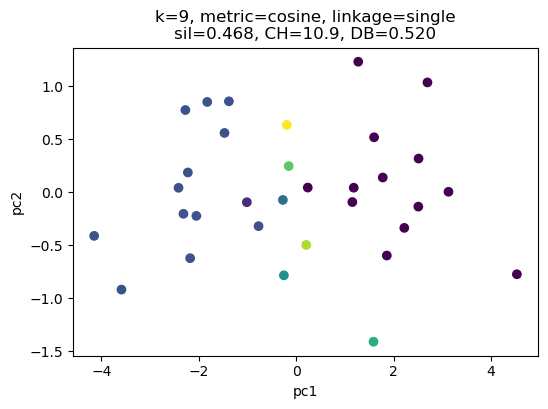

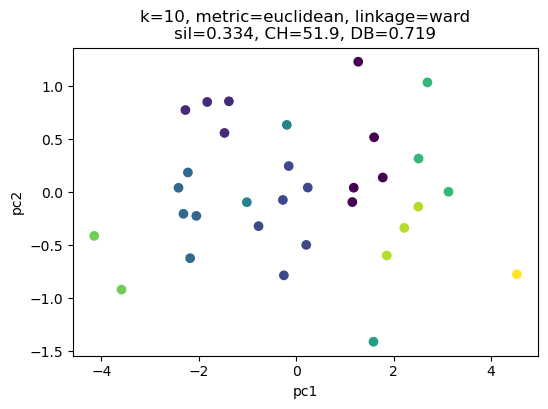

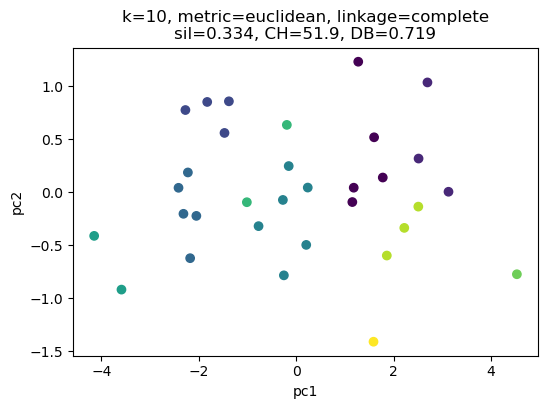

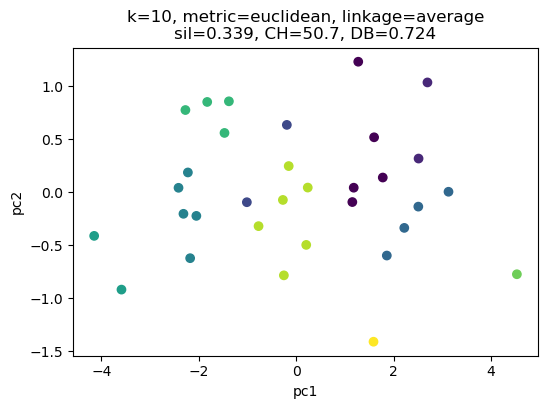

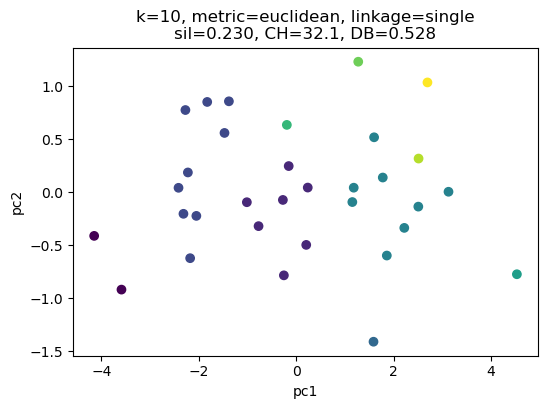

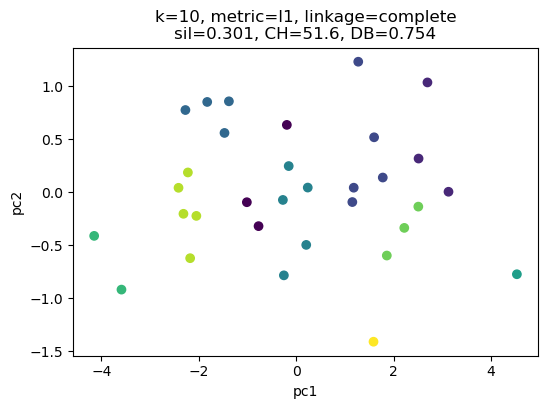

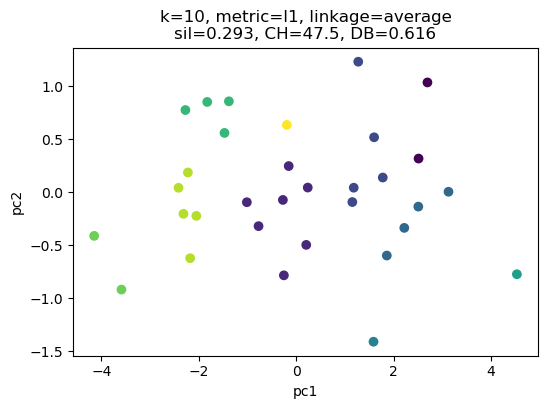

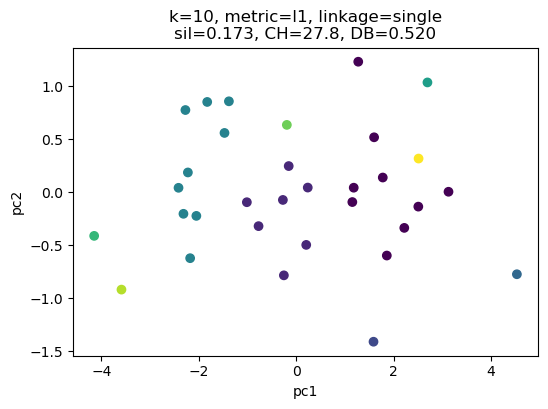

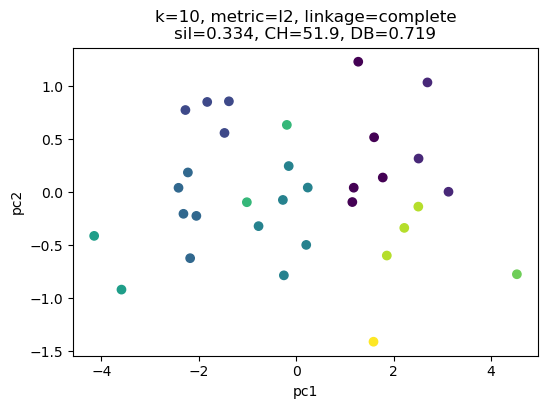

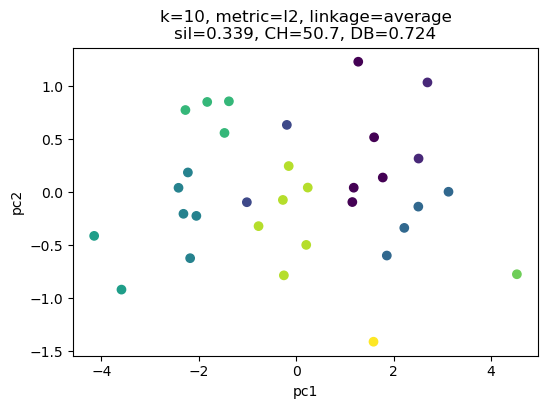

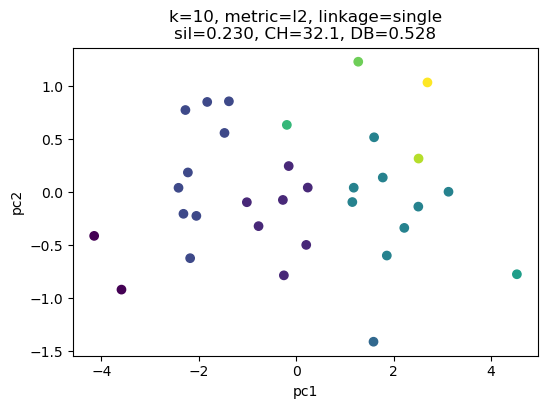

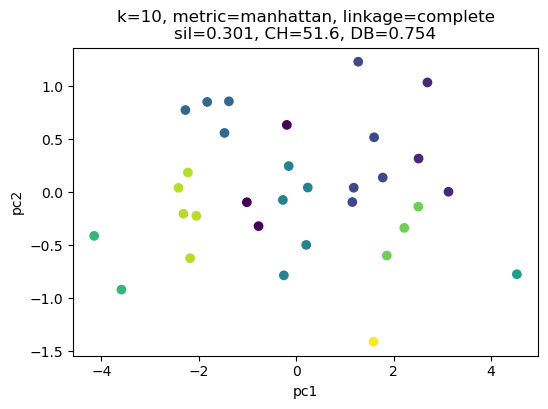

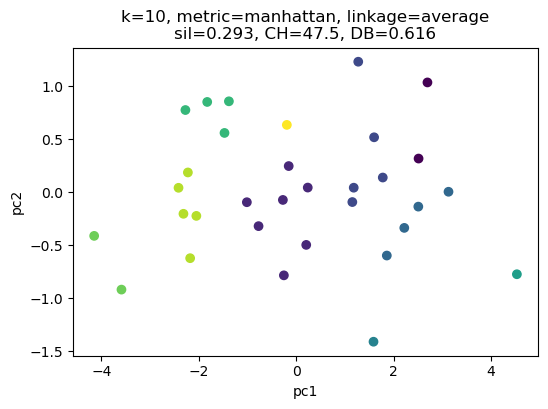

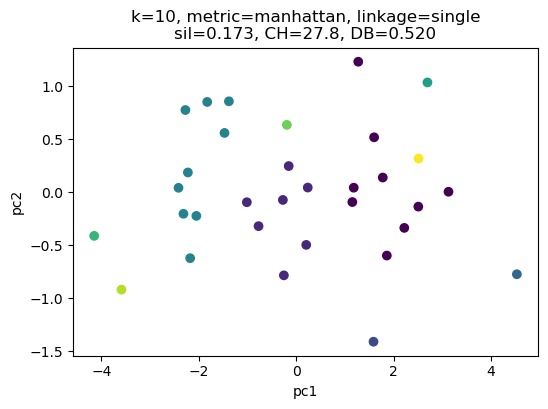

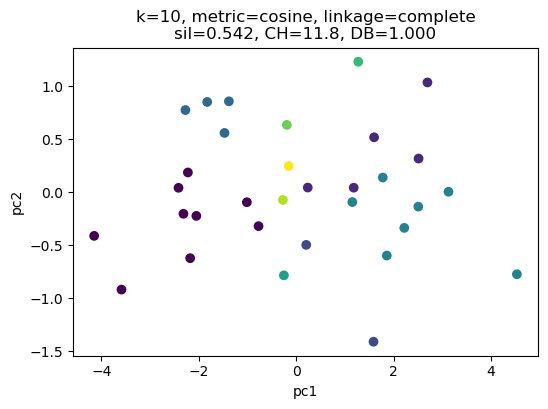

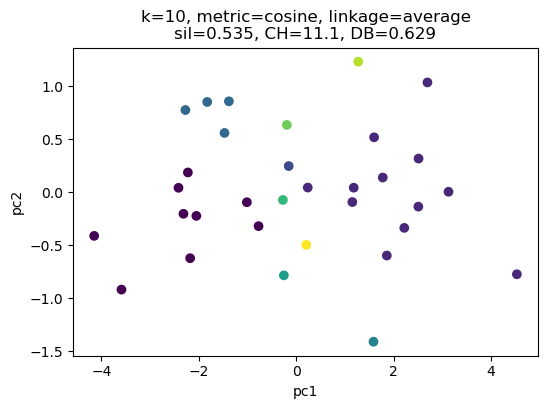

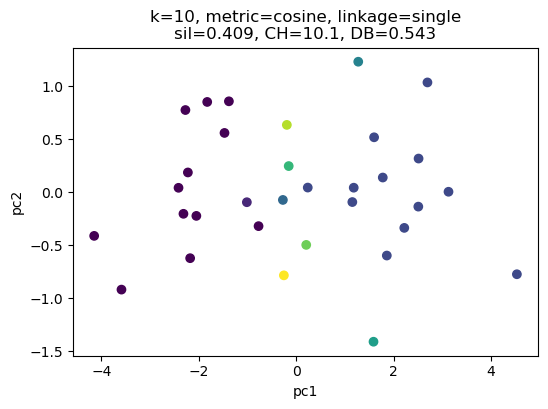

k     metric   linkage  silhouette  calinski_harabasz  davies_bouldin  \
13  6     cosine  complete    0.696136          17.152745        0.807657   
14  6     cosine   average    0.696136          17.152745        0.807657   
31  7     cosine    single    0.650621          13.777996        0.755892   
30  7     cosine   average    0.650621          13.777996        0.755892   
29  7     cosine  complete    0.619663          14.802576        0.786921   
.. ..        ...       ...         ...                ...             ...   
60  9  manhattan    single    0.171543          30.190926        0.500509   
6   6         l1    single    0.165532          17.079540        0.553538   
12  6  manhattan    single    0.165532          17.079540        0.553538   
3   6  euclidean    single    0.164468          17.079540        0.553538   
9   6         l2    single    0.164468          17.079540        0.553538   

    n_clusters_found  
13                 6  
14                 6  
31                 7  
30                 7  
29                 7  
..               ...  
60                 9  
6                  6  
12                 6  
3                  6  
9                  6  

[80 rows x 7 columns]

In [107]:
results = []

for k in range(6, 11):
    for metric_name in metrics:
        for linkage_name in links:
            # ward requires euclidean distance
            if linkage_name == "ward" and metric_name != "euclidean":
                continue

            # Fit hierarchical clustering
            model = AgglomerativeClustering(
                n_clusters=k,
                metric=metric_name,     # if your sklearn errors, change to affinity=metric_name
                linkage=linkage_name
            )
            labels = model.fit_predict(data)

            # Some metrics require >1 cluster and <n_samples clusters
            n_unique = len(np.unique(labels))
            if n_unique < 2 or n_unique >= len(data):
                continue

            # ---- Compute evaluation metrics ----
            # Silhouette:
            # - if metric is not euclidean, safest is to compute on a precomputed distance matrix
            try:
                if metric_name == "euclidean":
                    sil = silhouette_score(data, labels, metric="euclidean")
                else:
                    D = pairwise_distances(data, metric=metric_name)
                    sil = silhouette_score(D, labels, metric="precomputed")
            except Exception:
                sil = np.nan

            # CH and DB are defined on feature space (they assume euclidean geometry).
            # They're still often used on PCA/standardized numeric data. If you're using
            # non-euclidean distances, interpret these cautiously.
            try:
                ch = calinski_harabasz_score(data, labels)
            except Exception:
                ch = np.nan

            try:
                db = davies_bouldin_score(data, labels)
            except Exception:
                db = np.nan

            results.append({
                "k": k,
                "metric": metric_name,
                "linkage": linkage_name,
                "silhouette": sil,
                "calinski_harabasz": ch,
                "davies_bouldin": db,
                "n_clusters_found": n_unique
            })

            # ---- Optional plot ----
            plt.figure(figsize=(6, 4))
            plt.scatter(df5["pc1"], df5["pc2"], c=labels)
            plt.title(f"k={k}, metric={metric_name}, linkage={linkage_name}\n"
                      f"sil={sil:.3f}, CH={ch:.1f}, DB={db:.3f}")
            plt.xlabel("pc1")
            plt.ylabel("pc2")
            plt.show()

# Put results in a DataFrame for easy sorting/filtering
results_df = pd.DataFrame(results)

# Example: sort by best silhouette (descending) and best DB (ascending)
display(results_df.sort_values(["silhouette", "davies_bouldin"], ascending=[False, True]))


In [109]:
results_df.sort_values(["silhouette", "davies_bouldin"], ascending=[False, True]).head(10)

k  metric   linkage  silhouette  calinski_harabasz  davies_bouldin  \
13  6  cosine  complete    0.696136          17.152745        0.807657   
14  6  cosine   average    0.696136          17.152745        0.807657   
31  7  cosine    single    0.650621          13.777996        0.755892   
30  7  cosine   average    0.650621          13.777996        0.755892   
29  7  cosine  complete    0.619663          14.802576        0.786921   
15  6  cosine    single    0.609487          15.100311        0.801564   
47  8  cosine    single    0.596123          12.204525        0.489957   
45  8  cosine  complete    0.593542          14.224447        0.890934   
46  8  cosine   average    0.574148          12.211614        0.744219   
61  9  cosine  complete    0.571576          11.961273        0.841419   

    n_clusters_found  
13                 6  
14                 6  
31                 7  
30                 7  
29                 7  
15                 6  
47                 8  
45                 8  
46                 8  
61                 9

## Combine the 2 dataframes then sort to the top 10 of different k values, distances and links for hierarcgical 

In [112]:
results_all_df = pd.concat([results_df, results_df1])
results_all_df.sort_values(["silhouette", "davies_bouldin"], ascending=[False, True]).head(10)

k  metric   linkage  silhouette  calinski_harabasz  davies_bouldin  \
13  2  cosine  complete    0.782963          53.387525        0.658819   
14  2  cosine   average    0.782963          53.387525        0.658819   
29  3  cosine  complete    0.764019          33.152239        1.001574   
30  3  cosine   average    0.764019          33.152239        1.001574   
61  5  cosine  complete    0.721262          21.210002        0.854568   
62  5  cosine   average    0.721262          21.210002        0.854568   
13  6  cosine  complete    0.696136          17.152745        0.807657   
14  6  cosine   average    0.696136          17.152745        0.807657   
45  4  cosine  complete    0.695846          23.574601        0.886713   
46  4  cosine   average    0.695846          23.574601        0.886713   

    n_clusters_found  
13                 2  
14                 2  
29                 3  
30                 3  
61                 5  
62                 5  
13                 6  
14                 6  
45                 4  
46                 4

- Cosine seems to be the best metric for this clustering. This makes sense:
    - Euclidean distance measures absolute distance
    - Cosine  measures the angle between vectors
- what matters for this project is the similarity in personality traits refelcted in their angles. Characters with similar Big Five cscores cluster together


## compare KMeans  optimal k values with Hierarchical cluster to decide best method

In [115]:
pca_features = df5[['pc1', 'pc2', 'pc3']]

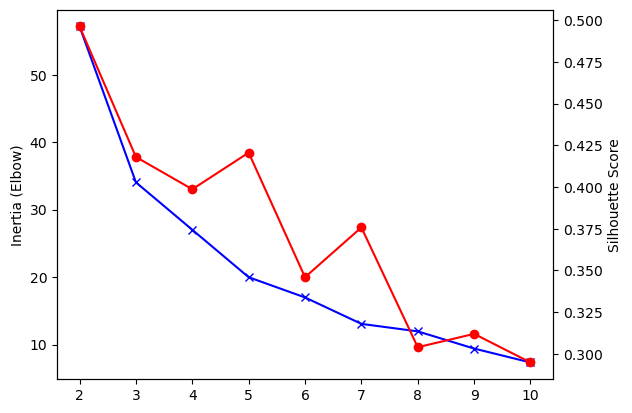

In [118]:
inertia = []
silhouette = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k,init='k-means++', random_state=42).fit(pca_features)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(pca_features, kmeans.labels_))

# Plot Elbow and Silhouette
fig, ax1 = plt.subplots()
ax1.plot(K_range, inertia, 'bx-')
ax1.set_ylabel('Inertia (Elbow)')
ax2 = ax1.twinx()
ax2.plot(K_range, silhouette, 'ro-')
ax2.set_ylabel('Silhouette Score')
plt.show()

**Model Selection: K-Means (Optimization) vs. Agglomerative (Clustering)**
- utilized K-Means Clustering as a benchmarking tool to identify the optimal k through the Elbow Method and Silhouette Analysis. However, for the final Hierarchical Tree, I implemented Agglomerative Clustering with Cosine Distance. 
- Unlike K-Means, which assumes spherical clusters, the Agglomerative approach with Cosine similarity better captures the shape of a personality; the relative ratios between traits, regardless of the absolute magnitude of the scores.

**NOTE**

**Cosine Distance (Clustering)**: was used when clustering to identify characters who share the same personality structure.

**Euclidean Distance:** was used in the application for person-to-character matching. It ensures a user is matched with a character of similar trait magnitude, preventing a 'moderate' user from being matched with an 'extreme' archetype.

In [122]:
# !pip install Kneed

In [124]:
kl = KneeLocator(K_range, inertia, curve='convex', direction='decreasing')
kl.elbow

5

In [126]:
kl = KneeLocator(K_range, silhouette, curve='convex', direction='decreasing')
kl.elbow

3

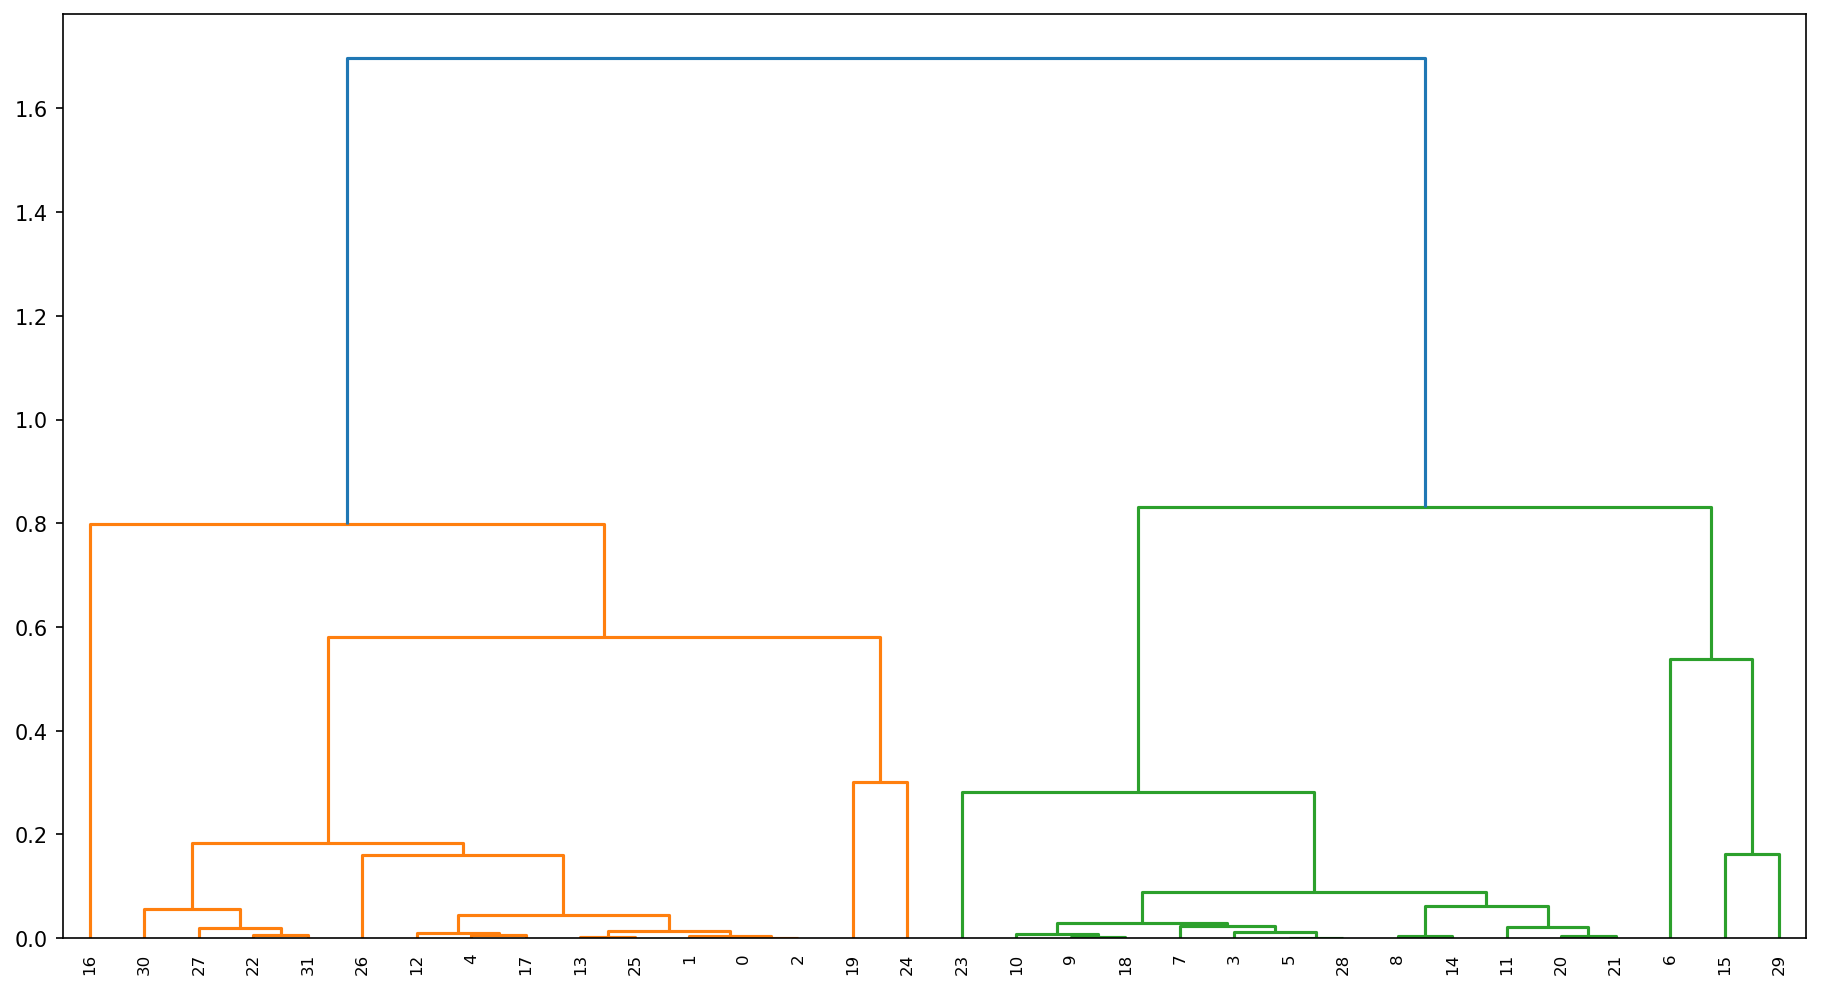

In [135]:
linkage_data = linkage(data, method='average', metric='cosine')
plt.figure(figsize=(15,8), dpi = 150)
dendrogram(linkage_data)
# plt.figure(figsize=(10,10), dpi = 150)
plt.xticks(rotation= 90)

plt.show()

- Will use 3 clusters
based on scores and data

In [138]:
df5['Final_Cluster'] = fcluster(linkage_data, t=3, criterion='maxclust')

#View who is in which group
for i in range(1, 4):
    print(f"\n--- Cluster {i} Members ---")
    print(df5[df5['Final_Cluster'] == i]['Character'].unique())


--- Cluster 1 Members ---
['Harry Potter' 'Hermione Granger' 'Ron Weasley' 'Rubeus Hagrid'
 'Alastor Moody' 'Draco Malfoy' 'Vernon Dursley' 'Arthur Weasley'
 'Cornelius Fudge' 'Neville Longbottom' 'Molly Weasley' 'Seamus Finnigan'
 'Luna Lovegood' 'Fred Weasley' 'George Weasley' 'Ginny Weasley']

--- Cluster 2 Members ---
['Albus Dumbledore' 'Severus Snape' 'Remus Lupin' 'Minerva McGonagall'
 'Voldemort' 'Tom Riddle' 'Sirius Black' 'Dolores Umbridge'
 'Bellatrix Lestrange' 'Dobby' 'Lucius Malfoy' 'Petunia Dursley'
 'Sybill Trelawney']

--- Cluster 3 Members ---
['Horace Slughorn' 'Gilderoy Lockhart' 'Argus Filch']


In [140]:
df5.head()

Character  Openness  Conscientiousness  Extraversion  Agreeableness  \
0      Harry Potter  4.251198           3.208040      3.392720       3.534280   
1  Hermione Granger  4.266085           3.226329      3.392671       3.536308   
2       Ron Weasley  4.188146           3.142979      3.334800       3.488475   
3  Albus Dumbledore  4.360914           3.358438      3.519773       3.627857   
4     Rubeus Hagrid  4.219483           3.158740      3.354983       3.474622   

   Neuroticism  Num_Chunks_Analyzed  Openness_scaled  \
0     2.583630                   45        -0.990045   
1     2.578651                   24        -0.739720   
2     2.614824                   22        -2.050260   
3     2.459145                   21         0.854821   
4     2.584393                   12        -1.523316   

   Conscientiousness_scaled  Extraversion_scaled  Agreeableness_scaled  \
0                 -1.298634            -0.957201             -1.121734   
1                 -1.081705            -0.957929             -1.083939   
2                 -2.070358            -1.820253             -1.975633   
3                  0.485307             0.935990              0.622684   
4                 -1.883400            -1.519508             -2.233873   

   Neuroticism_scaled       pc1       pc2       pc3  Final_Cluster  
0            0.786139 -2.312980 -0.203559  0.154788              1  
1            0.702269 -2.048080 -0.223219 -0.055361              1  
2            1.311554 -4.146219 -0.411959  0.237332              1  
3           -1.310597  1.862426 -0.597629  0.244361              2  
4            0.798993 -3.585591 -0.919253  0.116513              1

--- Average Personality Scores per Cluster --
               Openness_scaled  Conscientiousness_scaled  Extraversion_scaled  \
Final_Cluster                                                                   
1                    -0.845426                 -0.776051            -0.811657   
2                     0.964942                  0.876434             1.024149   
3                     0.327522                  0.341058            -0.109143   

               Agreeableness_scaled  Neuroticism_scaled  
Final_Cluster                                            
1                         -0.731203            0.784488  
2                          0.965960           -0.748704  
3                         -0.286079           -0.939548  


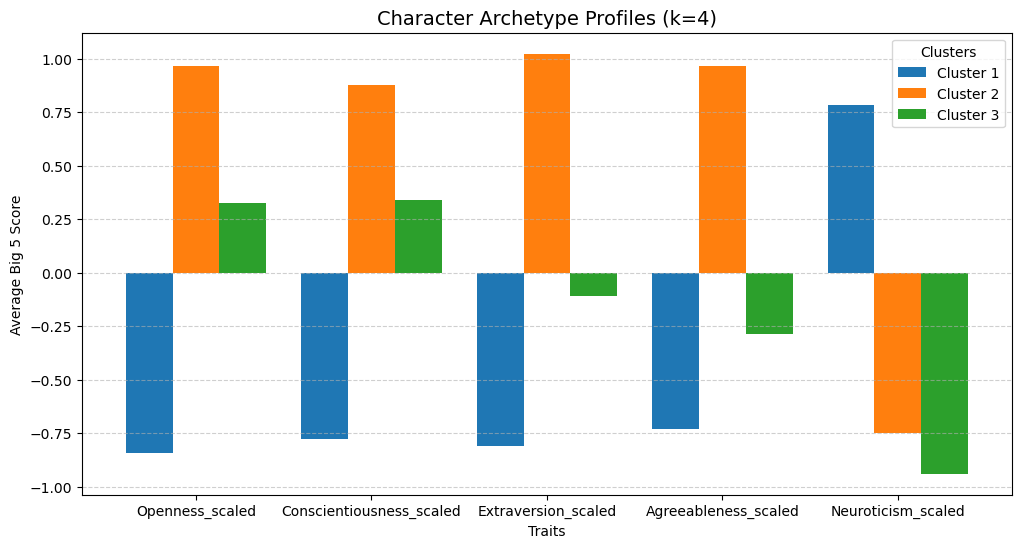

In [142]:
traits2 = ['Openness_scaled', 'Conscientiousness_scaled', 'Extraversion_scaled', 'Agreeableness_scaled' ,'Neuroticism_scaled']
cluster_profiles = df5.groupby('Final_Cluster')[traits2].mean()

print("--- Average Personality Scores per Cluster --")
print(cluster_profiles)

# 3. Visualize the "Personality Fingerprint" of each group
cluster_profiles.T.plot(kind='bar', figsize=(12, 6), width=0.8)

plt.title('Character Archetype Profiles (k=4)', fontsize=14)
plt.ylabel('Average Big 5 Score')
plt.xlabel('Traits')
plt.xticks(rotation=0)
plt.legend(title='Clusters', labels=['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

- 3d visualization of agglomerative clustering with k=3

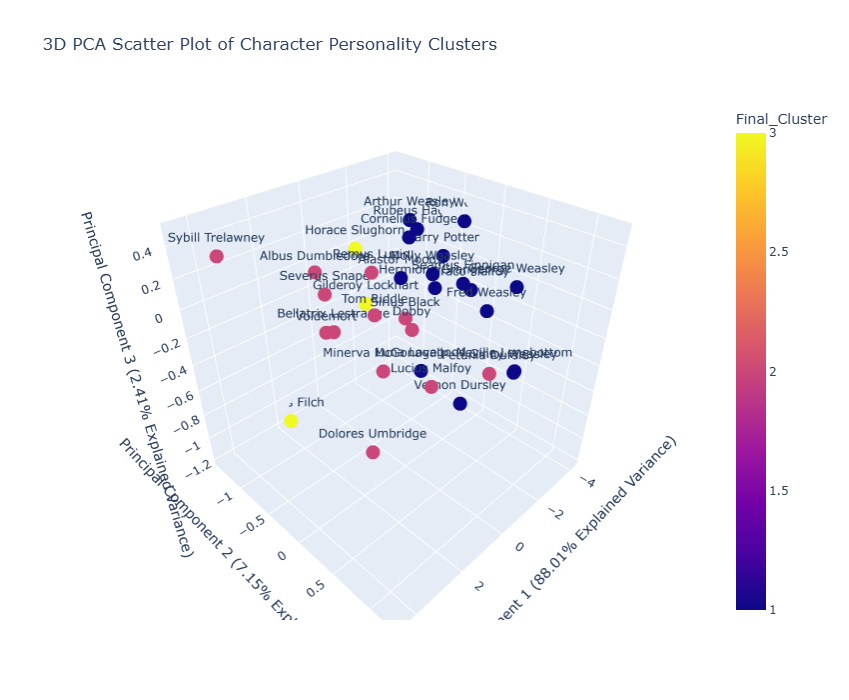

In [144]:
# Get explained variance ratios for axis titles
explained_var_pc1 = round(explained_variance_ratio[0] * 100, 2)
explained_var_pc2 = round(explained_variance_ratio[1] * 100, 2)
explained_var_pc3 = round(explained_variance_ratio[2] * 100, 2)

# Create an interactive 3D scatter plot
fig = px.scatter_3d(df5,
                    x='pc1',
                    y='pc2',
                    z='pc3',
                    color='Final_Cluster',
                    text='Character', # For persistent labels
                    hover_name='Character',
                    title='3D PCA Scatter Plot of Character Personality Clusters')

# Update layout for better readability and detailed axis titles
fig.update_layout(
    scene=dict(
        xaxis_title=f'Principal Component 1 ({explained_var_pc1}% Explained Variance)',
        yaxis_title=f'Principal Component 2 ({explained_var_pc2}% Explained Variance)',
        zaxis_title=f'Principal Component 3 ({explained_var_pc3}% Explained Variance)'
    ),
    legend_title_text='Cluster',
    height=700
)

fig.show()

- list top 10 characters of all big 5 personality traits

In [146]:
for trait in traits2:
    print(f"\n--- Top 10 Characters by {trait} ---")
    # Sort by the current trait in descending order and display the top 10
    top_characters = df5.sort_values(by=trait, ascending=False).head(10)
    display(top_characters[['Character', trait]])


--- Top 10 Characters by Openness_scaled ---


Character  Openness_scaled
9             Voldemort         1.624780
14     Dolores Umbridge         1.617497
28     Sybill Trelawney         1.374976
21        Lucius Malfoy         1.265636
18  Bellatrix Lestrange         1.199186
5         Severus Snape         1.049690
29          Argus Filch         0.983671
10           Tom Riddle         0.932650
8    Minerva McGonagall         0.884148
3      Albus Dumbledore         0.854821


--- Top 10 Characters by Conscientiousness_scaled ---


Character  Conscientiousness_scaled
28     Sybill Trelawney                  2.054766
29          Argus Filch                  1.429350
21        Lucius Malfoy                  1.352766
14     Dolores Umbridge                  1.300420
9             Voldemort                  1.202859
18  Bellatrix Lestrange                  1.166980
20                Dobby                  1.069793
5         Severus Snape                  0.796316
23      Petunia Dursley                  0.789557
10           Tom Riddle                  0.630882


--- Top 10 Characters by Extraversion_scaled ---


Character  Extraversion_scaled
28     Sybill Trelawney             2.169046
9             Voldemort             1.637657
21        Lucius Malfoy             1.499670
18  Bellatrix Lestrange             1.301542
5         Severus Snape             1.188823
10           Tom Riddle             1.024676
20                Dobby             0.954620
3      Albus Dumbledore             0.935990
7           Remus Lupin             0.756956
23      Petunia Dursley             0.699071


--- Top 10 Characters by Agreeableness_scaled ---


Character  Agreeableness_scaled
28     Sybill Trelawney              1.898252
21        Lucius Malfoy              1.638021
23      Petunia Dursley              1.310279
9             Voldemort              1.300804
14     Dolores Umbridge              1.269156
20                Dobby              0.905780
18  Bellatrix Lestrange              0.877027
10           Tom Riddle              0.801669
5         Severus Snape              0.777728
3      Albus Dumbledore              0.622684


--- Top 10 Characters by Neuroticism_scaled ---


Character  Neuroticism_scaled
22  Neville Longbottom            1.662093
31       Ginny Weasley            1.436651
2          Ron Weasley            1.311554
30      George Weasley            1.232074
25     Seamus Finnigan            1.087499
27        Fred Weasley            1.048590
13        Draco Malfoy            0.998072
4        Rubeus Hagrid            0.798993
0         Harry Potter            0.786139
1     Hermione Granger            0.702269

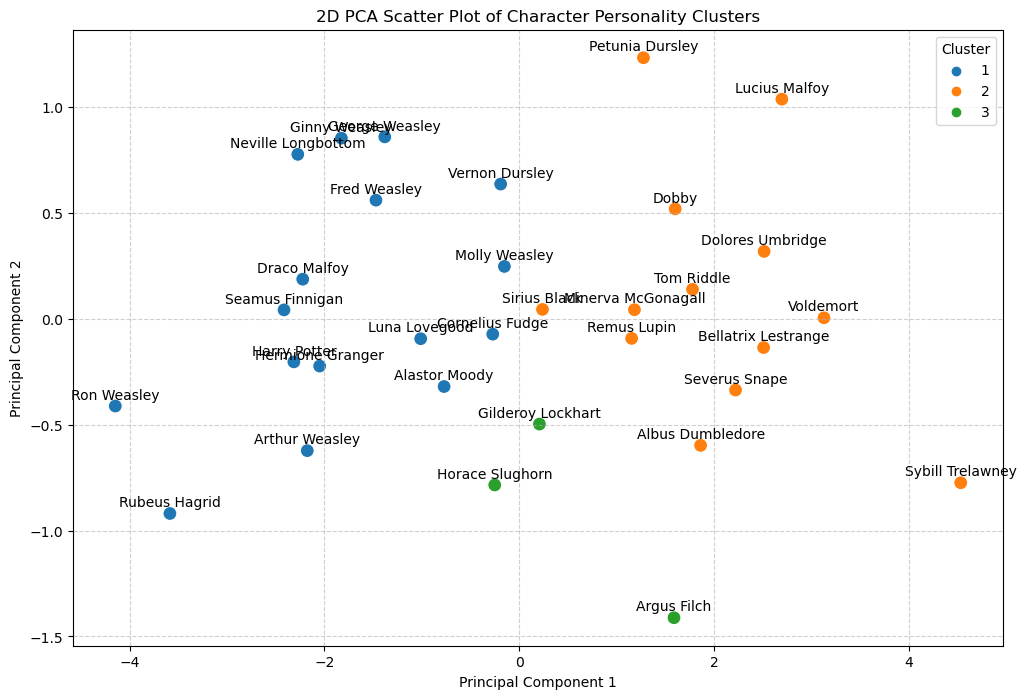

In [150]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='pc1', y='pc2', hue='Final_Cluster', data=df5, palette='tab10', s=100)

for i, row in df5.iterrows():
    plt.annotate(row['Character'], (row['pc1'], row['pc2']), textcoords="offset points", xytext=(0,5), ha='center')

plt.title('2D PCA Scatter Plot of Character Personality Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Cluster')
plt.show()

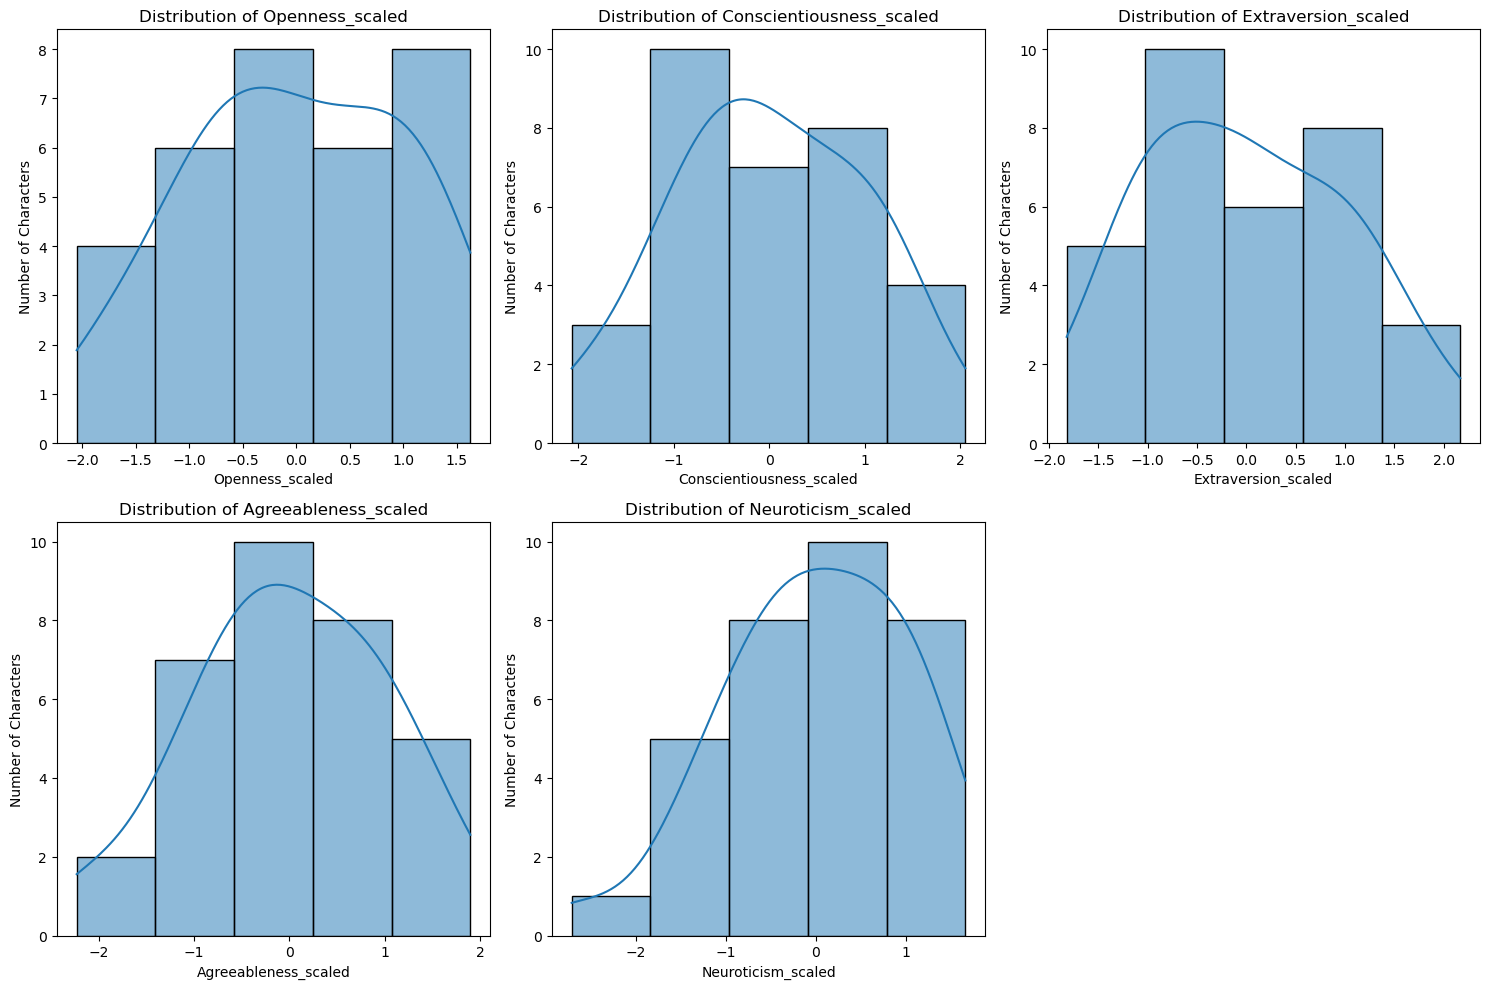

In [154]:
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(15, 10))
for i, trait in enumerate(traits2):
    plt.subplot(2, 3, i + 1) # Arrange in 2 rows, 3 columns
    sns.histplot(df5[trait], kde=True, bins=5)
    plt.title(f'Distribution of {trait}')
    plt.xlabel(trait)
    plt.ylabel('Number of Characters')
plt.tight_layout()
plt.show()

## discretize personality traits into to low-medium-high

In [156]:
scaled_traits = ['Openness_scaled', 'Conscientiousness_scaled', 'Extraversion_scaled', 'Agreeableness_scaled', 'Neuroticism_scaled']

# Calculate descriptive statistics for the scaled traits
scaled_trait_statistics = df5[scaled_traits].describe().loc[['mean', 'std', 'min', 'max']]

# Display the calculated statistics
print("Descriptive Statistics for Scaled Personality Traits:")
display(scaled_trait_statistics)

Descriptive Statistics for Scaled Personality Traits:


Openness_scaled  Conscientiousness_scaled  Extraversion_scaled  \
mean    -7.910339e-15              1.817990e-15         3.316791e-15   
std      1.016001e+00              1.016001e+00         1.016001e+00   
min     -2.050260e+00             -2.070358e+00        -1.820253e+00   
max      1.624780e+00              2.054766e+00         2.169046e+00   

      Agreeableness_scaled  Neuroticism_scaled  
mean         -3.622103e-15        1.859624e-15  
std           1.016001e+00        1.016001e+00  
min          -2.233873e+00       -2.710249e+00  
max           1.898252e+00        1.662093e+00

In [159]:
def func1(n):
    if n <= -.5:
        return 'Low'
    if n >= .5:
        return 'High'
    else:
        return 'Medium'

In [161]:
func1(2.054)

'High'

In [163]:
df_categ = df5.copy()

In [165]:
df_categ = df_categ.drop(['Openness','Conscientiousness','Extraversion','Agreeableness','Neuroticism','Num_Chunks_Analyzed'],axis=1)


In [169]:
df_categ['O'] = df_categ['Openness_scaled'].apply(func1)
df_categ['C'] = df_categ['Conscientiousness_scaled'].apply(func1)
df_categ['E'] = df_categ['Extraversion_scaled'].apply(func1)
df_categ['A'] = df_categ['Agreeableness_scaled'].apply(func1)
df_categ['N'] = df_categ['Neuroticism_scaled'].apply(func1)

In [171]:
df_categ.head()

Character  Openness_scaled  Conscientiousness_scaled  \
0      Harry Potter        -0.990045                 -1.298634   
1  Hermione Granger        -0.739720                 -1.081705   
2       Ron Weasley        -2.050260                 -2.070358   
3  Albus Dumbledore         0.854821                  0.485307   
4     Rubeus Hagrid        -1.523316                 -1.883400   

   Extraversion_scaled  Agreeableness_scaled  Neuroticism_scaled       pc1  \
0            -0.957201             -1.121734            0.786139 -2.312980   
1            -0.957929             -1.083939            0.702269 -2.048080   
2            -1.820253             -1.975633            1.311554 -4.146219   
3             0.935990              0.622684           -1.310597  1.862426   
4            -1.519508             -2.233873            0.798993 -3.585591   

        pc2       pc3  Final_Cluster     O       C     E     A     N  
0 -0.203559  0.154788              1   Low     Low   Low   Low  High  
1 -0.223219 -0.055361              1   Low     Low   Low   Low  High  
2 -0.411959  0.237332              1   Low     Low   Low   Low  High  
3 -0.597629  0.244361              2  High  Medium  High  High   Low  
4 -0.919253  0.116513              1   Low     Low   Low   Low  High

In [173]:
df_categ['O'].value_counts(), df_categ['C'].value_counts()

(O
 Low       12
 High      11
 Medium     9
 Name: count, dtype: int64,
 C
 Medium    12
 Low       10
 High      10
 Name: count, dtype: int64)

In [175]:
df_categ['E'].value_counts(), df_categ['A'].value_counts(), df_categ['N'].value_counts()

(E
 Low       11
 High      11
 Medium    10
 Name: count, dtype: int64,
 A
 High      12
 Low       11
 Medium     9
 Name: count, dtype: int64,
 N
 High      11
 Low       11
 Medium    10
 Name: count, dtype: int64)

In [177]:
cols_to_plot =['O','C', 'E', 'A', 'N']

# Melt the DataFrame to long format
df_melted = df_categ.melt(value_vars=cols_to_plot, var_name='variable', value_name='value')

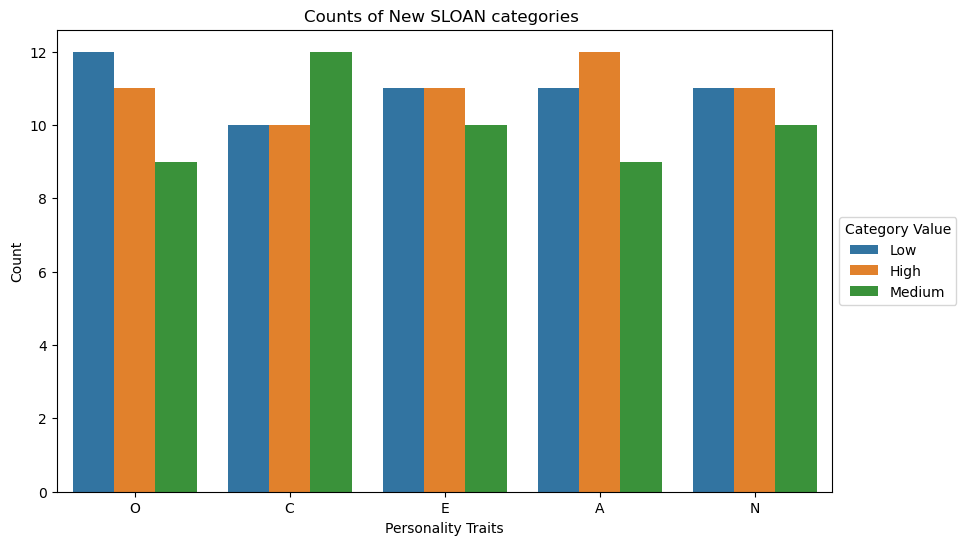

In [179]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_melted, x='variable', hue='value')
plt.title('Counts of New SLOAN categories ')
plt.xlabel('Personality Traits')
plt.ylabel('Count')
plt.legend(title='Category Value',loc='center left', bbox_to_anchor=(1, 0.5))


plt.show()

In [181]:
# 1. Define the columns and thresholds
scaled_cols = ['Openness_scaled', 'Conscientiousness_scaled', 'Extraversion_scaled', 'Agreeableness_scaled', 'Neuroticism_scaled']
lower = -0.5
upper = 0.5

# 2. Define the counting logic
def get_trait_counts(row):
    high = (row[scaled_cols] > upper).sum()
    low = (row[scaled_cols] < lower).sum()
    medium = ((row[scaled_cols] >= lower) & (row[scaled_cols] <= upper)).sum()
    return pd.Series([high, medium, low], index=['High_Count', 'Medium_Count', 'Low_Count'])

# 3. Apply and combine with Character names
tally_df = df5[scaled_cols].apply(get_trait_counts, axis=1)
result_df = pd.concat([df5['Character'], tally_df], axis=1)

# 4. Sort by High_Count to see the most 'extreme' characters first
print(result_df.sort_values(by=['High_Count', 'Medium_Count'], ascending=False))

              Character  High_Count  Medium_Count  Low_Count
21        Lucius Malfoy           4             1          0
5         Severus Snape           4             0          1
9             Voldemort           4             0          1
10           Tom Riddle           4             0          1
14     Dolores Umbridge           4             0          1
18  Bellatrix Lestrange           4             0          1
28     Sybill Trelawney           4             0          1
20                Dobby           3             2          0
23      Petunia Dursley           3             2          0
3      Albus Dumbledore           3             1          1
7           Remus Lupin           3             1          1
8    Minerva McGonagall           2             3          0
29          Argus Filch           2             2          1
16       Vernon Dursley           1             4          0
27         Fred Weasley           1             2          2
30       George Weasley 

In [183]:
important_characters = ['Draco Malfoy', 'Harry Potter', 'Hermione Granger', 'Ron Weasley', 'Rubeus Hagrid', 'Neville Longbottom', 'Ginny Weasley', 'Alastor Moody', 'Gilderoy Lockhart', 'Horace Slughorn', 'Bellatrix Lestrange', 'Dolores Umbridge', 'Severus Snape', 'Voldemort', 'Albus Dumbledore', 'Remus Lupin', 'Lucious Malfoy','Dobby', 'Minerva McGonagall', 'Sirius Black']

## convert binned trait scores (low, medium, high) into a 'soft sloan' encoding

In [186]:
def get_hybrid_sloan(row):
    # Trait mapping logic
    # Extraversion -> S/R
    if row['Extraversion_scaled'] > 0.5: val_e = 'S'
    elif row['Extraversion_scaled'] > 0: val_e = 's'
    elif row['Extraversion_scaled'] >= -0.5: val_e = 'r'
    else: val_e = 'R'
        
    # Neuroticism -> L/C
    if row['Neuroticism_scaled'] > 0.5: val_n = 'L'
    elif row['Neuroticism_scaled'] > 0: val_n = 'l'
    elif row['Neuroticism_scaled'] >= -0.5: val_n = 'c'
    else: val_n = 'C'
        
    # Conscientiousness -> O/U
    if row['Conscientiousness_scaled'] > 0.5: val_c = 'O'
    elif row['Conscientiousness_scaled'] > 0: val_c = 'o'
    elif row['Conscientiousness_scaled'] >= -0.5: val_c = 'u'
    else: val_c = 'U'
        
    # Agreeableness -> A/E
    if row['Agreeableness_scaled'] > 0.5: val_a = 'A'
    elif row['Agreeableness_scaled'] > 0: val_a = 'a'
    elif row['Agreeableness_scaled'] >= -0.5: val_a = 'e'
    else: val_a = 'E'
        
    # Openness -> I/N
    if row['Openness_scaled'] > 0.5: val_o = 'I'
    elif row['Openness_scaled'] > 0: val_o = 'i'
    elif row['Openness_scaled'] >= -0.5: val_o = 'n'
    else: val_o = 'N'
    
    return f"{val_e}{val_n}{val_c}{val_a}{val_o}"

# Apply to df5
df5['Hybrid_SLOAN'] = df5.apply(get_hybrid_sloan, axis=1)

# Preview the 'Extreme' vs 'Balanced' characters
print(df5[['Character', 'Hybrid_SLOAN','Final_Cluster']].sort_values(by='Hybrid_SLOAN'))

              Character Hybrid_SLOAN  Final_Cluster
0          Harry Potter        RLUEN              1
1      Hermione Granger        RLUEN              1
2           Ron Weasley        RLUEN              1
22   Neville Longbottom        RLUEN              1
4         Rubeus Hagrid        RLUEN              1
13         Draco Malfoy        RLUEN              1
31        Ginny Weasley        RLUeN              1
25      Seamus Finnigan        RLuEN              1
27         Fred Weasley        RLueN              1
17       Arthur Weasley        RlUEN              1
26        Luna Lovegood        RluEn              1
9             Voldemort        SCOAI              2
10           Tom Riddle        SCOAI              2
28     Sybill Trelawney        SCOAI              2
5         Severus Snape        SCOAI              2
14     Dolores Umbridge        SCOAI              2
18  Bellatrix Lestrange        SCOAI              2
7           Remus Lupin        SCoAI              2
3      Albus

In [188]:
df_categ['Hybrid_SLOAN'] = df_categ.apply(get_hybrid_sloan, axis=1)

In [192]:
df_categ.sample(5)

Character  Openness_scaled  Conscientiousness_scaled  \
0         Harry Potter        -0.990045                 -1.298634   
22  Neville Longbottom        -0.515030                 -1.059514   
27        Fred Weasley        -0.868630                 -0.433636   
28    Sybill Trelawney         1.374976                  2.054766   
30      George Weasley        -0.867146                 -0.551188   

    Extraversion_scaled  Agreeableness_scaled  Neuroticism_scaled       pc1  \
0             -0.957201             -1.121734            0.786139 -2.312980   
22            -1.226704             -0.676921            1.662093 -2.272743   
27            -0.619990             -0.351048            1.048590 -1.470242   
28             2.169046              1.898252           -2.710249  4.533310   
30            -0.395852             -0.090773            1.232074 -1.379667   

         pc2       pc3  Final_Cluster     O       C       E       A     N  \
0  -0.203559  0.154788              1   Low     Low     Low     Low  High   
22  0.776359 -0.402473              1   Low     Low     Low     Low  High   
27  0.560027  0.031391              1   Low  Medium     Low  Medium  High   
28 -0.774249  0.480442              2  High    High    High    High   Low   
30  0.858766  0.265735              1   Low     Low  Medium  Medium  High   

   Hybrid_SLOAN  
0         RLUEN  
22        RLUEN  
27        RLueN  
28        SCOAI  
30        rLUeN

## see the SLOAN encodings distribution within clusters

In [194]:
cluster_col = "Final_Cluster"     # k=4
sloan_col = "Hybrid_SLOAN"

sloan_counts = (
    df5.groupby([cluster_col, sloan_col])
       .size()
       .reset_index(name="count")
       .sort_values([cluster_col, "count"], ascending=[True, False])
)

# show top 10 Sloan codes per cluster
top_n = 10
for c in sorted(df5[cluster_col].unique()):
    print(f"\n=== Cluster {c}: Top {top_n} SLOAN codes ===")
    display(sloan_counts[sloan_counts[cluster_col] == c].head(top_n))


=== Cluster 1: Top 10 SLOAN codes ===


Final_Cluster Hybrid_SLOAN  count
0              1        RLUEN      6
1              1        RLUeN      1
2              1        RLuEN      1
3              1        RLueN      1
4              1        RlUEN      1
5              1        RluEn      1
6              1        rLUeN      1
7              1        rLoai      1
8              1        rluEn      1
9              1        scuen      1


=== Cluster 2: Top 10 SLOAN codes ===


Final_Cluster Hybrid_SLOAN  count
11              2        SCOAI      6
12              2        SCoAI      2
13              2        ScOAI      1
14              2        ScOAi      1
15              2        SlOAi      1
16              2        scoAI      1
17              2        sluai      1


=== Cluster 3: Top 10 SLOAN codes ===


Final_Cluster Hybrid_SLOAN  count
18              3        rCOeI      1
19              3        rCoen      1
20              3        sCUEi      1

In [196]:
cluster_sizes = df5.groupby(cluster_col).size().rename("cluster_size")
# see the dominant SLOAN for each cluster
top_code = (
    df5.groupby([cluster_col, sloan_col])
       .size()
       .rename("count")
       .reset_index()
       .merge(cluster_sizes.reset_index(), on=cluster_col)
)

top_code["pct"] = top_code["count"] / top_code["cluster_size"]

top_code_summary = (
    top_code.sort_values([cluster_col, "count"], ascending=[True, False])
            .groupby(cluster_col)
            .head(1)
            .sort_values(cluster_col)
)

display(top_code_summary)

Final_Cluster Hybrid_SLOAN  count  cluster_size       pct
0               1        RLUEN      6            16  0.375000
11              2        SCOAI      6            13  0.461538
18              3        rCOeI      1             3  0.333333

In [201]:
cluster_col = "Final_Cluster"
sloan_col = "Hybrid_SLOAN"
name_col = "Character"

cluster_sloan_chars = (
    df5.groupby([cluster_col, sloan_col])[name_col]
       .apply(list)
       .reset_index()
       .sort_values([cluster_col, sloan_col])
)

for c in sorted(df5[cluster_col].unique()):
    print(f"\n==============================")
    print(f"Cluster {c}: SLOAN breakdown")
    print(f"==============================")
    sub = cluster_sloan_chars[cluster_sloan_chars[cluster_col] == c]
    for _, row in sub.iterrows():
        print(f"{row[sloan_col]:>6} : {row[name_col]}")



Cluster 1: SLOAN breakdown
 RLUEN : ['Harry Potter', 'Hermione Granger', 'Ron Weasley', 'Rubeus Hagrid', 'Draco Malfoy', 'Neville Longbottom']
 RLUeN : ['Ginny Weasley']
 RLuEN : ['Seamus Finnigan']
 RLueN : ['Fred Weasley']
 RlUEN : ['Arthur Weasley']
 RluEn : ['Luna Lovegood']
 rLUeN : ['George Weasley']
 rLoai : ['Vernon Dursley']
 rluEn : ['Alastor Moody']
 scuen : ['Cornelius Fudge']
 sloaN : ['Molly Weasley']

Cluster 2: SLOAN breakdown
 SCOAI : ['Severus Snape', 'Voldemort', 'Tom Riddle', 'Dolores Umbridge', 'Bellatrix Lestrange', 'Sybill Trelawney']
 SCoAI : ['Albus Dumbledore', 'Remus Lupin']
 ScOAI : ['Lucius Malfoy']
 ScOAi : ['Dobby']
 SlOAi : ['Petunia Dursley']
 scoAI : ['Minerva McGonagall']
 sluai : ['Sirius Black']

Cluster 3: SLOAN breakdown
 rCOeI : ['Argus Filch']
 rCoen : ['Gilderoy Lockhart']
 sCUEi : ['Horace Slughorn']


In [203]:
from collections import Counter

cluster_col = "Final_Cluster"
sloan_col = "Hybrid_SLOAN"

def letter_freq(series):
    all_letters = "".join(series.fillna("").astype(str).tolist())
    return Counter([ch for ch in all_letters if ch != "_"])

letter_rows = []
for c, sub in df5.groupby(cluster_col):
    freq = letter_freq(sub[sloan_col])
    row = {"cluster": c, **freq}
    letter_rows.append(row)

letter_freq_df = pd.DataFrame(letter_rows).fillna(0).set_index("cluster").astype(int)
display(letter_freq_df)

R   L  U   E   N  r  l  u  n  o  a  i  s  c  e   S  C   A   I  O
cluster                                                                   
1        11  11  9  10  12  3  4  5  3  2  2  1  2  1  4   0  0   0   0  0
2         0   0  0   0   0  0  2  1  0  3  1  3  2  3  0  11  8  12  10  9
3         0   0  1   1   0  2  0  0  1  1  0  1  1  0  2   0  3   0   1  1

In [205]:
cluster_col = "Final_Cluster"

level_cols = [
    "O",
    "C",
    "E",
    "A",
    "N"
]

long_intervals = df_categ.melt(
    id_vars=[cluster_col],
    value_vars=level_cols,
    var_name="Trait",
    value_name="Level"
)

interval_counts = (
    long_intervals
    .groupby([cluster_col, "Trait", "Level"])
    .size()
    .reset_index(name="Count")
    .sort_values([cluster_col, "Trait", "Count"], ascending=[True, True, False])
)

display(interval_counts)

Final_Cluster Trait   Level  Count
0               1     A     Low     10
1               1     A  Medium      6
2               1     C     Low      9
3               1     C  Medium      7
4               1     E     Low     11
5               1     E  Medium      5
6               1     N    High     11
7               1     N  Medium      5
8               1     O     Low     12
9               1     O  Medium      4
10              2     A    High     12
11              2     A  Medium      1
12              2     C    High      9
13              2     C  Medium      4
14              2     E    High     11
15              2     E  Medium      2
16              2     N     Low      8
17              2     N  Medium      5
18              2     O    High     10
19              2     O  Medium      3
21              3     A  Medium      2
20              3     A     Low      1
22              3     C    High      1
23              3     C     Low      1
24              3     C  Medium      1
25              3     E  Medium      3
26              3     N     Low      3
28              3     O  Medium      2
27              3     O    High      1

In [207]:
interval_majority = (
    interval_counts
    .groupby([cluster_col, "Trait"])
    .apply(lambda x: x.loc[x["Count"].idxmax()])
    .reset_index(drop=True)
    .pivot(index=cluster_col, columns="Trait", values="Level")
)

display(interval_majority)

Trait               A     C       E     N       O
Final_Cluster                                    
1                 Low   Low     Low  High     Low
2                High  High    High   Low    High
3              Medium  High  Medium   Low  Medium

In [209]:
interval_pct_df = (
    long_intervals
    .groupby([cluster_col, "Trait", "Level"])
    .size()
    .rename("Count") # Give a name to the size series
    .reset_index() # Now we have a DataFrame with columns: Final_Cluster, Trait, Level, Count
)

# Calculate percentages using transform after grouping
interval_pct_df['Pct'] = interval_pct_df.groupby([cluster_col, "Trait"])['Count'].transform(lambda x: 100 * x / x.sum())

interval_confidence = (
    interval_pct_df
    .sort_values([cluster_col, "Trait", "Pct"], ascending=[True, True, False])
    .groupby([cluster_col, "Trait"])
    .head(1)
    .pivot(index=cluster_col, columns="Trait", values="Pct")
)

display(interval_confidence)

Trait                  A          C           E           N          O
Final_Cluster                                                         
1              62.500000  56.250000   68.750000   68.750000  75.000000
2              92.307692  69.230769   84.615385   61.538462  76.923077
3              66.666667  33.333333  100.000000  100.000000  66.666667

In [211]:
sloan_letter_pct = (
    letter_freq_df
    .div(letter_freq_df.sum(axis=1), axis=0)
    .round(3)
)

display(sloan_letter_pct)

R      L      U      E     N      r      l      u      n      o  \
cluster                                                                        
1        0.138  0.138  0.112  0.125  0.15  0.038  0.050  0.062  0.038  0.025   
2        0.000  0.000  0.000  0.000  0.00  0.000  0.031  0.015  0.000  0.046   
3        0.000  0.000  0.067  0.067  0.00  0.133  0.000  0.000  0.067  0.067   

             a      i      s      c      e      S      C      A      I      O  
cluster                                                                        
1        0.025  0.012  0.025  0.012  0.050  0.000  0.000  0.000  0.000  0.000  
2        0.015  0.046  0.031  0.046  0.000  0.169  0.123  0.185  0.154  0.138  
3        0.000  0.067  0.067  0.000  0.133  0.000  0.200  0.000  0.067  0.067

- to prepare for the streamlit app, will need to add cluster information for k=2-10


--- Clusters for k=2 ---

--- Cluster 1 Members (k=2) ---
['Harry Potter' 'Hermione Granger' 'Ron Weasley' 'Rubeus Hagrid'
 'Alastor Moody' 'Draco Malfoy' 'Vernon Dursley' 'Arthur Weasley'
 'Cornelius Fudge' 'Neville Longbottom' 'Molly Weasley' 'Seamus Finnigan'
 'Luna Lovegood' 'Fred Weasley' 'George Weasley' 'Ginny Weasley']

--- Cluster 2 Members (k=2) ---
['Albus Dumbledore' 'Severus Snape' 'Horace Slughorn' 'Remus Lupin'
 'Minerva McGonagall' 'Voldemort' 'Tom Riddle' 'Sirius Black'
 'Dolores Umbridge' 'Gilderoy Lockhart' 'Bellatrix Lestrange' 'Dobby'
 'Lucius Malfoy' 'Petunia Dursley' 'Sybill Trelawney' 'Argus Filch']


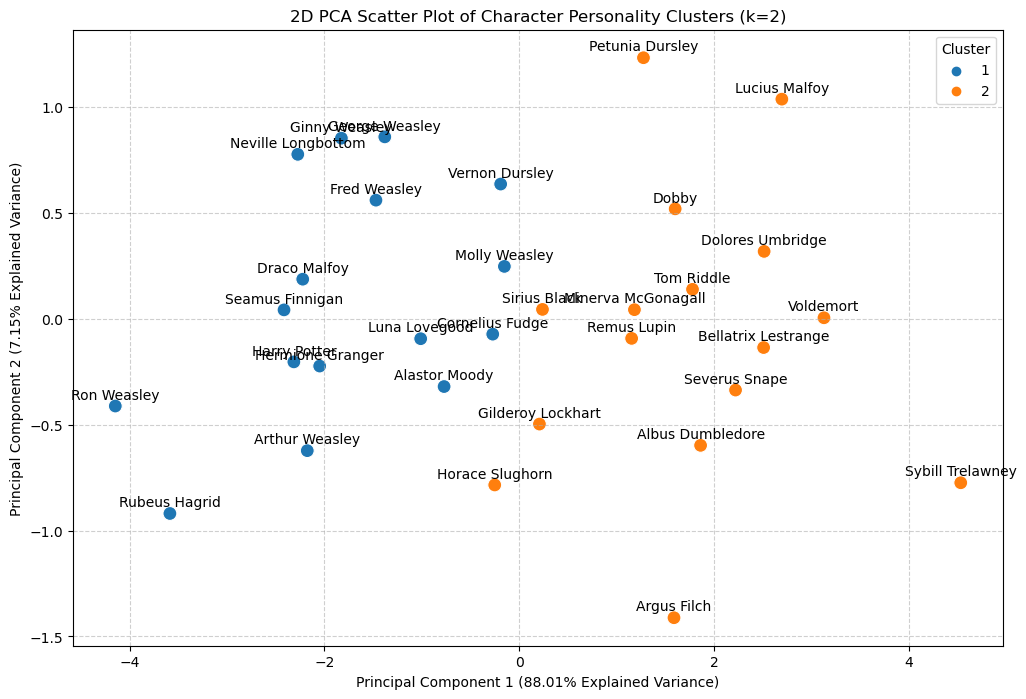


--- Clusters for k=4 ---

--- Cluster 1 Members (k=4) ---
['Harry Potter' 'Hermione Granger' 'Ron Weasley' 'Rubeus Hagrid'
 'Alastor Moody' 'Draco Malfoy' 'Arthur Weasley' 'Cornelius Fudge'
 'Neville Longbottom' 'Molly Weasley' 'Seamus Finnigan' 'Luna Lovegood'
 'Fred Weasley' 'George Weasley' 'Ginny Weasley']

--- Cluster 2 Members (k=4) ---
['Vernon Dursley']

--- Cluster 3 Members (k=4) ---
['Albus Dumbledore' 'Severus Snape' 'Remus Lupin' 'Minerva McGonagall'
 'Voldemort' 'Tom Riddle' 'Sirius Black' 'Dolores Umbridge'
 'Bellatrix Lestrange' 'Dobby' 'Lucius Malfoy' 'Petunia Dursley'
 'Sybill Trelawney']

--- Cluster 4 Members (k=4) ---
['Horace Slughorn' 'Gilderoy Lockhart' 'Argus Filch']


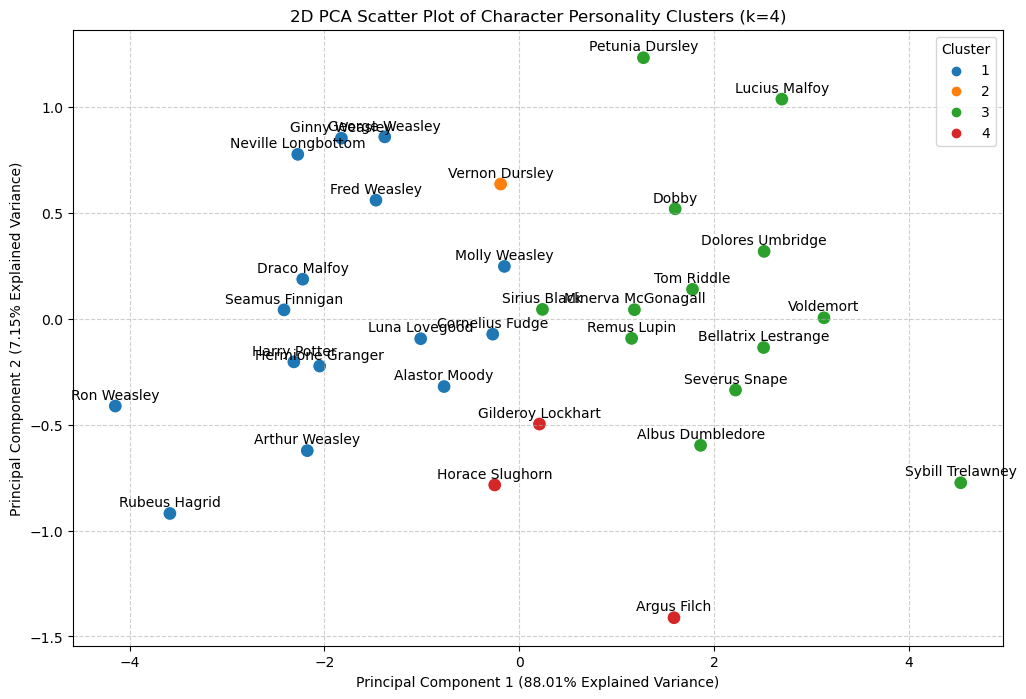


--- Clusters for k=5 ---

--- Cluster 1 Members (k=5) ---
['Harry Potter' 'Hermione Granger' 'Ron Weasley' 'Rubeus Hagrid'
 'Alastor Moody' 'Draco Malfoy' 'Arthur Weasley' 'Neville Longbottom'
 'Seamus Finnigan' 'Luna Lovegood' 'Fred Weasley' 'George Weasley'
 'Ginny Weasley']

--- Cluster 2 Members (k=5) ---
['Cornelius Fudge' 'Molly Weasley']

--- Cluster 3 Members (k=5) ---
['Vernon Dursley']

--- Cluster 4 Members (k=5) ---
['Albus Dumbledore' 'Severus Snape' 'Remus Lupin' 'Minerva McGonagall'
 'Voldemort' 'Tom Riddle' 'Sirius Black' 'Dolores Umbridge'
 'Bellatrix Lestrange' 'Dobby' 'Lucius Malfoy' 'Petunia Dursley'
 'Sybill Trelawney']

--- Cluster 5 Members (k=5) ---
['Horace Slughorn' 'Gilderoy Lockhart' 'Argus Filch']


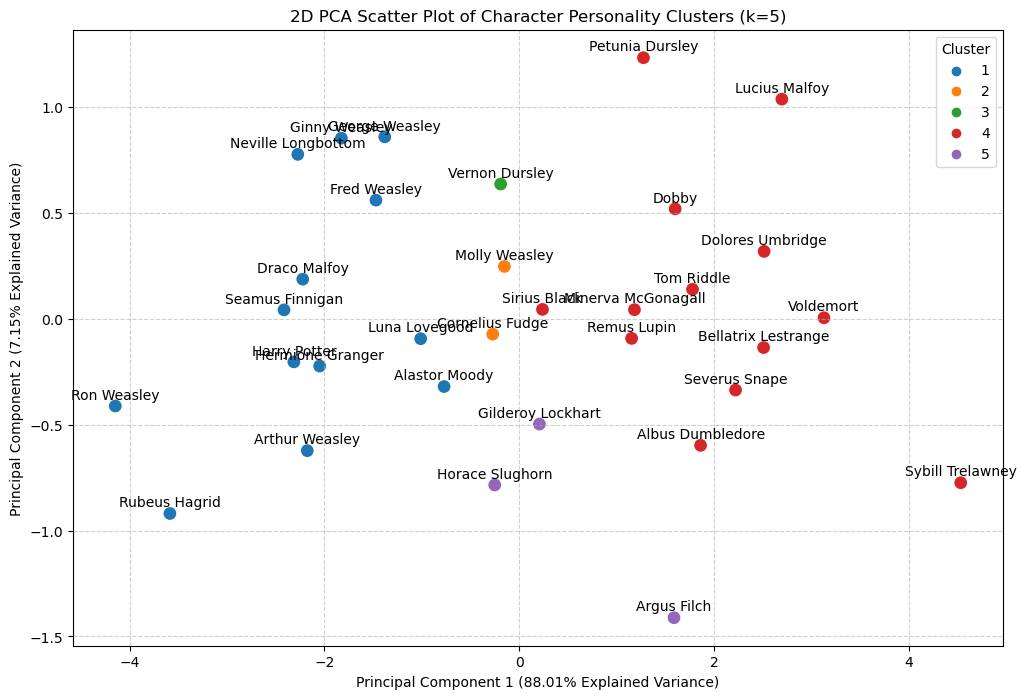


--- Clusters for k=6 ---

--- Cluster 1 Members (k=6) ---
['Harry Potter' 'Hermione Granger' 'Ron Weasley' 'Rubeus Hagrid'
 'Alastor Moody' 'Draco Malfoy' 'Arthur Weasley' 'Neville Longbottom'
 'Seamus Finnigan' 'Luna Lovegood' 'Fred Weasley' 'George Weasley'
 'Ginny Weasley']

--- Cluster 2 Members (k=6) ---
['Cornelius Fudge' 'Molly Weasley']

--- Cluster 3 Members (k=6) ---
['Vernon Dursley']

--- Cluster 4 Members (k=6) ---
['Albus Dumbledore' 'Severus Snape' 'Remus Lupin' 'Minerva McGonagall'
 'Voldemort' 'Tom Riddle' 'Sirius Black' 'Dolores Umbridge'
 'Bellatrix Lestrange' 'Dobby' 'Lucius Malfoy' 'Petunia Dursley'
 'Sybill Trelawney']

--- Cluster 5 Members (k=6) ---
['Gilderoy Lockhart' 'Argus Filch']

--- Cluster 6 Members (k=6) ---
['Horace Slughorn']


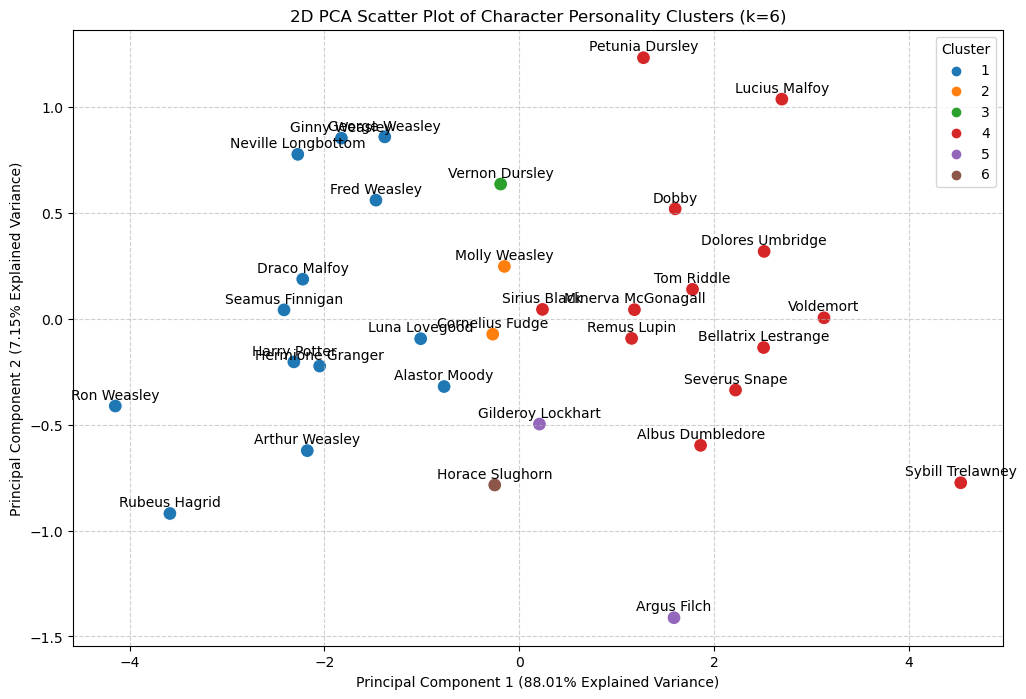


--- Clusters for k=7 ---

--- Cluster 1 Members (k=7) ---
['Harry Potter' 'Hermione Granger' 'Ron Weasley' 'Rubeus Hagrid'
 'Alastor Moody' 'Draco Malfoy' 'Arthur Weasley' 'Neville Longbottom'
 'Seamus Finnigan' 'Luna Lovegood' 'Fred Weasley' 'George Weasley'
 'Ginny Weasley']

--- Cluster 2 Members (k=7) ---
['Cornelius Fudge']

--- Cluster 3 Members (k=7) ---
['Molly Weasley']

--- Cluster 4 Members (k=7) ---
['Vernon Dursley']

--- Cluster 5 Members (k=7) ---
['Albus Dumbledore' 'Severus Snape' 'Remus Lupin' 'Minerva McGonagall'
 'Voldemort' 'Tom Riddle' 'Sirius Black' 'Dolores Umbridge'
 'Bellatrix Lestrange' 'Dobby' 'Lucius Malfoy' 'Petunia Dursley'
 'Sybill Trelawney']

--- Cluster 6 Members (k=7) ---
['Gilderoy Lockhart' 'Argus Filch']

--- Cluster 7 Members (k=7) ---
['Horace Slughorn']


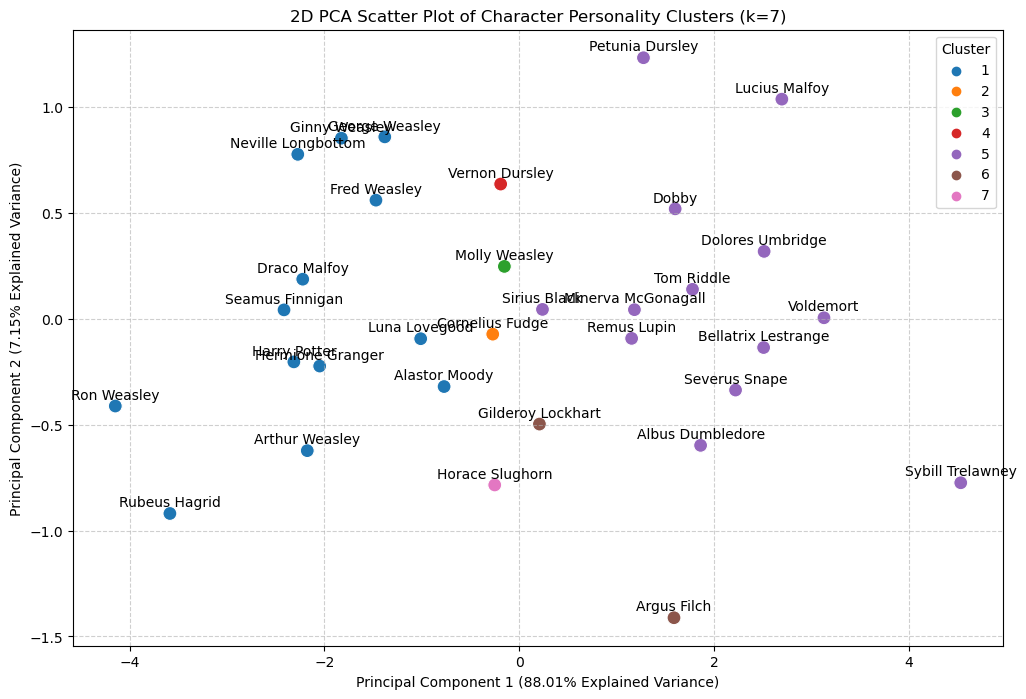


--- Clusters for k=8 ---

--- Cluster 1 Members (k=8) ---
['Harry Potter' 'Hermione Granger' 'Ron Weasley' 'Rubeus Hagrid'
 'Alastor Moody' 'Draco Malfoy' 'Arthur Weasley' 'Neville Longbottom'
 'Seamus Finnigan' 'Luna Lovegood' 'Fred Weasley' 'George Weasley'
 'Ginny Weasley']

--- Cluster 2 Members (k=8) ---
['Cornelius Fudge']

--- Cluster 3 Members (k=8) ---
['Molly Weasley']

--- Cluster 4 Members (k=8) ---
['Vernon Dursley']

--- Cluster 5 Members (k=8) ---
['Albus Dumbledore' 'Severus Snape' 'Remus Lupin' 'Minerva McGonagall'
 'Voldemort' 'Tom Riddle' 'Sirius Black' 'Dolores Umbridge'
 'Bellatrix Lestrange' 'Dobby' 'Lucius Malfoy' 'Sybill Trelawney']

--- Cluster 6 Members (k=8) ---
['Petunia Dursley']

--- Cluster 7 Members (k=8) ---
['Gilderoy Lockhart' 'Argus Filch']

--- Cluster 8 Members (k=8) ---
['Horace Slughorn']


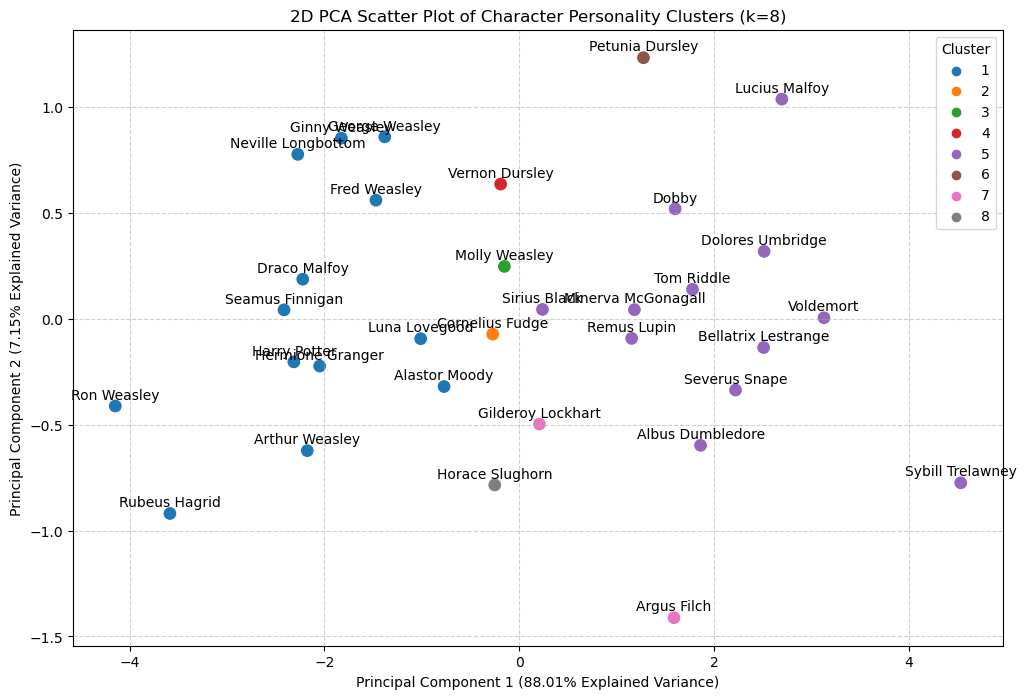


--- Clusters for k=9 ---

--- Cluster 1 Members (k=9) ---
['Neville Longbottom' 'Fred Weasley' 'George Weasley' 'Ginny Weasley']

--- Cluster 2 Members (k=9) ---
['Harry Potter' 'Hermione Granger' 'Ron Weasley' 'Rubeus Hagrid'
 'Alastor Moody' 'Draco Malfoy' 'Arthur Weasley' 'Seamus Finnigan'
 'Luna Lovegood']

--- Cluster 3 Members (k=9) ---
['Cornelius Fudge']

--- Cluster 4 Members (k=9) ---
['Molly Weasley']

--- Cluster 5 Members (k=9) ---
['Vernon Dursley']

--- Cluster 6 Members (k=9) ---
['Albus Dumbledore' 'Severus Snape' 'Remus Lupin' 'Minerva McGonagall'
 'Voldemort' 'Tom Riddle' 'Sirius Black' 'Dolores Umbridge'
 'Bellatrix Lestrange' 'Dobby' 'Lucius Malfoy' 'Sybill Trelawney']

--- Cluster 7 Members (k=9) ---
['Petunia Dursley']

--- Cluster 8 Members (k=9) ---
['Gilderoy Lockhart' 'Argus Filch']

--- Cluster 9 Members (k=9) ---
['Horace Slughorn']


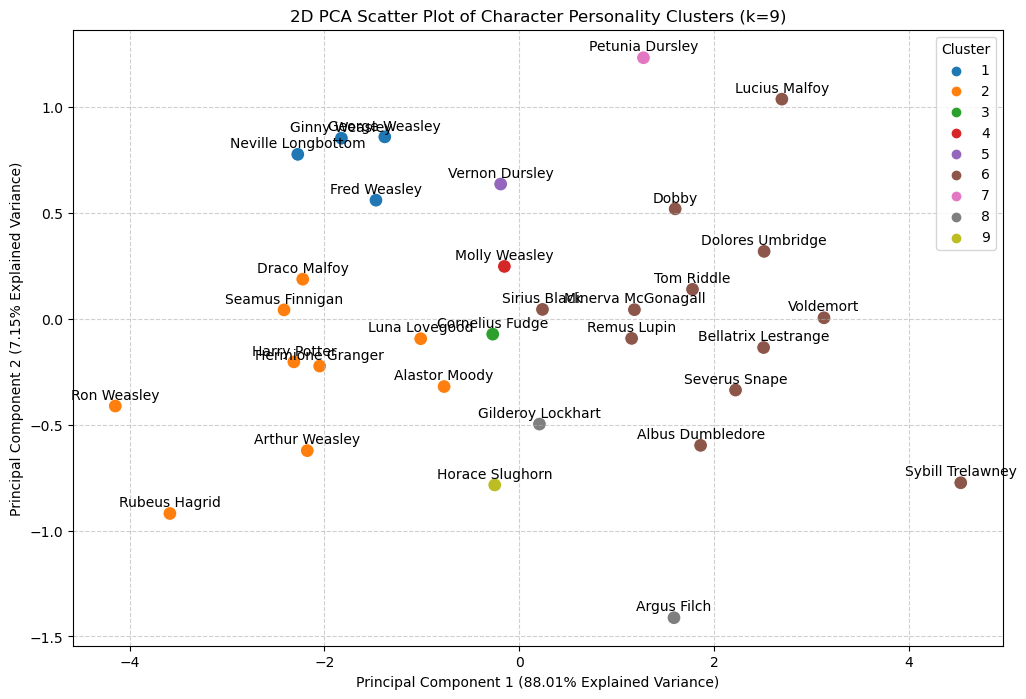


--- Clusters for k=10 ---

--- Cluster 1 Members (k=10) ---
['Neville Longbottom' 'Fred Weasley' 'George Weasley' 'Ginny Weasley']

--- Cluster 2 Members (k=10) ---
['Harry Potter' 'Hermione Granger' 'Ron Weasley' 'Rubeus Hagrid'
 'Alastor Moody' 'Draco Malfoy' 'Arthur Weasley' 'Seamus Finnigan'
 'Luna Lovegood']

--- Cluster 3 Members (k=10) ---
['Cornelius Fudge']

--- Cluster 4 Members (k=10) ---
['Molly Weasley']

--- Cluster 5 Members (k=10) ---
['Vernon Dursley']

--- Cluster 6 Members (k=10) ---
['Albus Dumbledore' 'Severus Snape' 'Remus Lupin' 'Minerva McGonagall'
 'Voldemort' 'Tom Riddle' 'Sirius Black' 'Dolores Umbridge'
 'Bellatrix Lestrange' 'Dobby' 'Lucius Malfoy' 'Sybill Trelawney']

--- Cluster 7 Members (k=10) ---
['Petunia Dursley']

--- Cluster 8 Members (k=10) ---
['Gilderoy Lockhart']

--- Cluster 9 Members (k=10) ---
['Argus Filch']

--- Cluster 10 Members (k=10) ---
['Horace Slughorn']


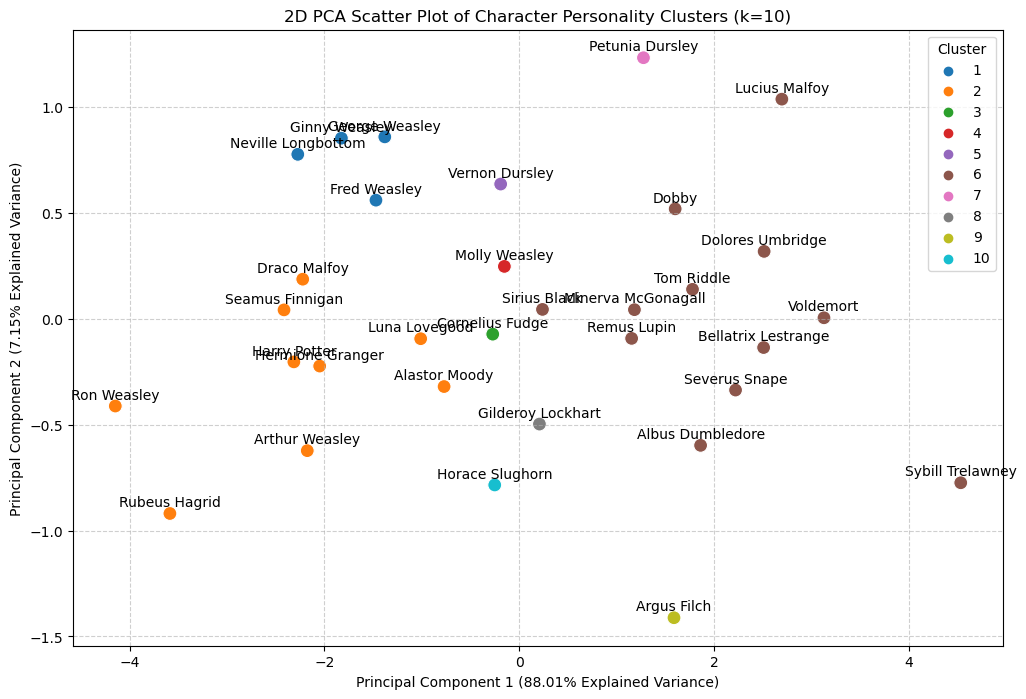

In [214]:
explained_var_pc1 = round(pca.explained_variance_ratio_[0] * 100, 2)
explained_var_pc2 = round(pca.explained_variance_ratio_[1] * 100, 2)
explained_var_pc3 = round(pca.explained_variance_ratio_[2] * 100, 2)

k_values_to_process = [2,4,5,6,7,8,9,10]

for k in k_values_to_process:
    cluster_column_name = f'Final_Cluster_k{k}'
    df5[cluster_column_name] = fcluster(linkage_data, t=k, criterion='maxclust')

    print(f"\n--- Clusters for k={k} ---")
    for i in range(1, k + 1):
        print(f"\n--- Cluster {i} Members (k={k}) ---")
        print(df5[df5[cluster_column_name] == i]['Character'].unique())

    # Generate and display a 2D PCA scatter plot for the current k
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='pc1', y='pc2', hue=cluster_column_name, data=df5, palette='tab10', s=100)

    for i, row in df5.iterrows():
        plt.annotate(row['Character'], (row['pc1'], row['pc2']), textcoords="offset points", xytext=(0,5), ha='center')

    plt.title(f'2D PCA Scatter Plot of Character Personality Clusters (k={k})')
    plt.xlabel(f'Principal Component 1 ({explained_var_pc1}% Explained Variance)')
    plt.ylabel(f'Principal Component 2 ({explained_var_pc2}% Explained Variance)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title='Cluster')
    plt.show()

In [ ]:
df5.rename({'Final_Cluster': 'Cluster'}, axis=1, inplace=True)

In [220]:
df5.head()

Character  Openness  Conscientiousness  Extraversion  Agreeableness  \
0      Harry Potter  4.251198           3.208040      3.392720       3.534280   
1  Hermione Granger  4.266085           3.226329      3.392671       3.536308   
2       Ron Weasley  4.188146           3.142979      3.334800       3.488475   
3  Albus Dumbledore  4.360914           3.358438      3.519773       3.627857   
4     Rubeus Hagrid  4.219483           3.158740      3.354983       3.474622   

   Neuroticism  Num_Chunks_Analyzed  Openness_scaled  \
0     2.583630                   45        -0.990045   
1     2.578651                   24        -0.739720   
2     2.614824                   22        -2.050260   
3     2.459145                   21         0.854821   
4     2.584393                   12        -1.523316   

   Conscientiousness_scaled  Extraversion_scaled  ...  Cluster  Hybrid_SLOAN  \
0                 -1.298634            -0.957201  ...        1         RLUEN   
1                 -1.081705            -0.957929  ...        1         RLUEN   
2                 -2.070358            -1.820253  ...        1         RLUEN   
3                  0.485307             0.935990  ...        2         SCoAI   
4                 -1.883400            -1.519508  ...        1         RLUEN   

   Final_Cluster_k2  Final_Cluster_k4  Final_Cluster_k5  Final_Cluster_k6  \
0                 1                 1                 1                 1   
1                 1                 1                 1                 1   
2                 1                 1                 1                 1   
3                 2                 3                 4                 4   
4                 1                 1                 1                 1   

  Final_Cluster_k7  Final_Cluster_k8  Final_Cluster_k9  Final_Cluster_k10  
0                1                 1                 2                  2  
1                1                 1                 2                  2  
2                1                 1                 2                  2  
3                5                 5                 6                  6  
4                1                 1                 2                  2  

[5 rows x 25 columns]

In [ ]:
df5.to_csv('df5.csv')
df_categ.to_csv('df_categ.csv')